# Exploratory Data Analysis (EDA)
In this notebook, I will perform exploratory data analysis (EDA) on the university_mental_health_iot_dataset.csv, aiming to identify underlying feature correlations and their effect on the target variable.

## 1.1 Initial Dataset Observations
Let's load the dataset and observe its basic statistics:

In [232]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import shap

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)     
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_colwidth', None) 

In [233]:
df = pd.read_csv('assets/university_mental_health_iot_dataset.csv')
df.head(10)

timestamp  location_id  temperature_celsius  humidity_percent  air_quality_index  noise_level_db  lighting_lux  crowd_density  stress_level  sleep_hours  mood_score  mental_health_status
0  2024-05-01 08:00:00          104            24.328184         62.987529                 67       54.429034    323.015836             45            23         7.22         2.3                     0
1  2024-05-01 08:15:00          105            26.177300         52.482089                 77       62.336451    412.211259             17            54         5.02         1.7                     1
2  2024-05-01 08:30:00          103            25.443028         55.736424                120       51.967691    386.972786             35            39         4.96         2.9                     0
3  2024-05-01 08:45:00          105            24.671652         71.484457                131       54.658851    339.056874             25            39         8.24         0.0                     0
4  2024-05-01 09:00:00          105            21.628577         61.132704                 81       60.623440    341.460697             36            18         6.61         3.0                     0
5  2024-05-01 09:15:00          102            25.414405         45.617220                 58       51.121999    346.139255             58            35         6.50         1.6                     0
6  2024-05-01 09:30:00          103            29.646073         69.192289                 77       52.022026    287.951643             38            36         7.56         2.0                     0
7  2024-05-01 09:45:00          103            28.036260         53.318559                118       43.232965    314.339645             12            46         9.68         2.5                     1
8  2024-05-01 10:00:00          103            28.779560         78.732978                 63       54.850632    328.716025             45            24         5.79         1.0                     0
9  2024-05-01 10:15:00          105            22.466353         70.800481                 48       51.651515    293.660870             52            20         7.64         1.3                     0

At first glance, the dataset appears to be a classic time series set, with timestamps spaced 15 minutes apart. Most of the remaining columns seem to be numeric. While they might represent categorical concepts, there are no traditional 'string'-type categories present.

The data clearly follows an ordered sequence, with each row occurring 15 minutes after the previous one. This suggests that we might be dealing with a time series problem. Are there observable patterns over time — for example, does someone appear more stressed in the morning and then more or less relaxed later at night? Or is the timestamp simply a tabular feature, representing a static slice of data at a given moment? These are the questions that need to be explored.

Additionally, most features can be considered continuous or numeric (with the exception of location_id and mental_health_status), so we are not working with classic categorical data.

In [234]:
print("=== (N Rows, N Columns):", df.shape)
print("\n=== Missing values per column:\n", df.isnull().sum())

=== (N Rows, N Columns): (1000, 12)

=== Missing values per column:
 timestamp               0
location_id             0
temperature_celsius     0
humidity_percent        0
air_quality_index       0
noise_level_db          0
lighting_lux            0
crowd_density           0
stress_level            0
sleep_hours             0
mood_score              0
mental_health_status    0
dtype: int64


It is a relatively small dataset, which consists of 1000 records and 12 columns. Luckily, there are no missing values!

In [235]:
print("\n=== Duplicated entries:", df.duplicated().sum())
print("\n=== Descriptive statistics:\n", df.describe())


=== Duplicated entries: 0

=== Descriptive statistics:
        location_id  temperature_celsius  humidity_percent  air_quality_index  noise_level_db  lighting_lux  crowd_density  stress_level  sleep_hours   mood_score  mental_health_status
count  1000.000000          1000.000000       1000.000000        1000.000000     1000.000000   1000.000000    1000.000000   1000.000000  1000.000000  1000.000000           1000.000000
mean    103.004000            24.208457         60.189320          85.446000       54.722387    301.500435      31.736000     39.086000     6.423930     1.641000              0.501000
std       1.433192             3.012801          9.747296          37.970526       10.051077     48.873955      15.757366     13.416057     1.170662     1.016076              0.512115
min     101.000000            15.235949         29.804878          20.000000       24.540712    155.222115       5.000000      1.000000     3.000000    -2.200000              0.000000
25%     102.000000     

The dataset has no duplicate entries. Some values are clearly integers, while others are floats. location_id is a categorical variable, and it appears that there are only five unique location IDs in the dataset.

What caught my attention at this point is that mental_health_status is not binary, as I initially assumed.

In [236]:
print("\n=== Unique Values:\n", df.nunique())


=== Unique Values:
 timestamp               1000
location_id                5
temperature_celsius     1000
humidity_percent        1000
air_quality_index        130
noise_level_db          1000
lighting_lux            1000
crowd_density             55
stress_level              72
sleep_hours              408
mood_score                45
mental_health_status       3
dtype: int64


We will now check whether there are gaps in the timestamps - in other words, if any of the expected time intervals are missing. Upon examination, there are no missing timestamps, and the data is consistently recorded at 15-minute intervals.

In [237]:
expected_freq = '15min'

expected_range = pd.date_range(
    start = df['timestamp'].min(),
    end   = df['timestamp'].max(),
    freq  = expected_freq
)
actual_timestamps  = pd.to_datetime(df['timestamp'])
missing_timestamps = expected_range.difference(actual_timestamps)
print('Missing timestamps: ', missing_timestamps)

Missing timestamps:  DatetimeIndex([], dtype='datetime64[ns]', freq='15min')


## 1.2 Feature Exploration
We will now take a closer look at the features in the dataset.

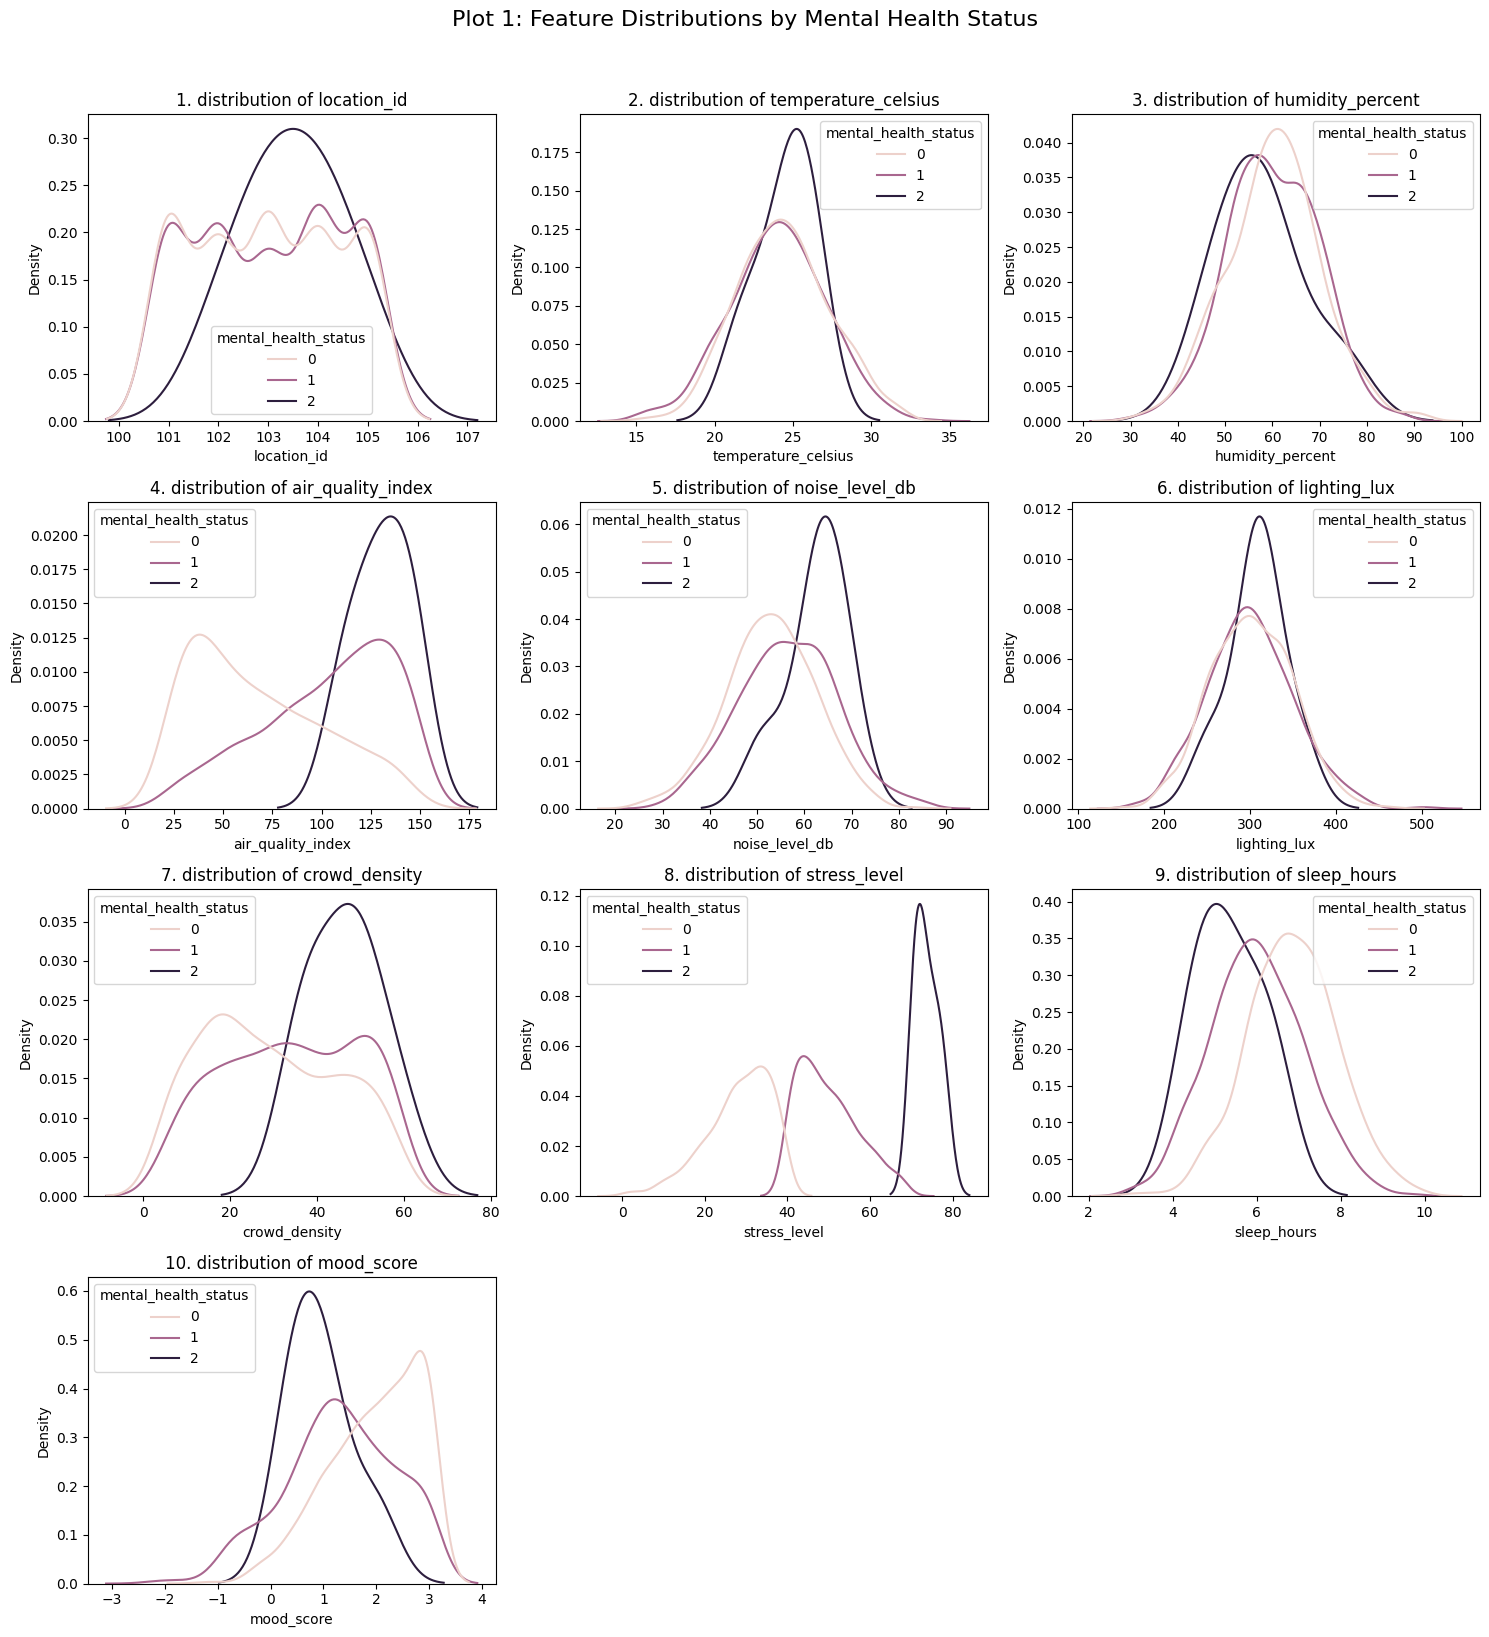

In [238]:
plot_df = df.copy()
columns_to_plot = plot_df.columns.drop('timestamp').drop('mental_health_status')
n_cols = 3
n_rows = math.ceil(len(columns_to_plot) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=df, x=col, hue='mental_health_status', common_norm=False, fill=False)
    plt.title(f'{i}. distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.suptitle('Plot 1: Feature Distributions by Mental Health Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Most of the distributions above are bell-shaped, which is typical for many data types derived from natural observations. As expected, location_id, being a categorical feature, shows a more uniform distribution.

## 1.3 Outlier Detection

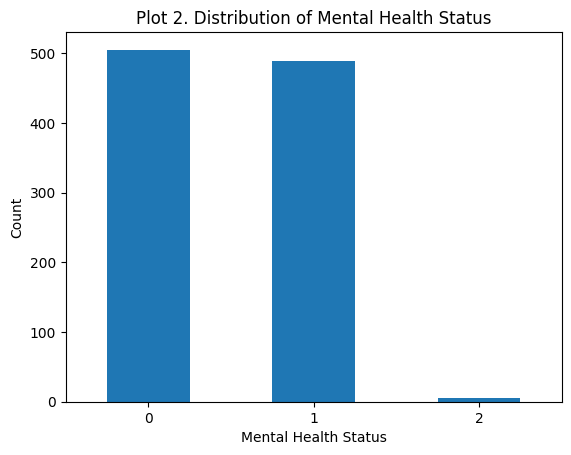

In [239]:
plot_df['timestamp'] = pd.to_datetime(df['timestamp'])
plot_df['mental_health_status'].value_counts().sort_index().plot(kind='bar')
plt.title('Plot 2. Distribution of Mental Health Status')
plt.xlabel('Mental Health Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The distribution of mental_health_status continues to raise questions and appears to be an outlier within the dataset. Unfortunately, I don’t have any domain knowledge about the expected range of mental health values, but it seems like this variable should have been a binary outcome. Let’s take a closer look at its values:

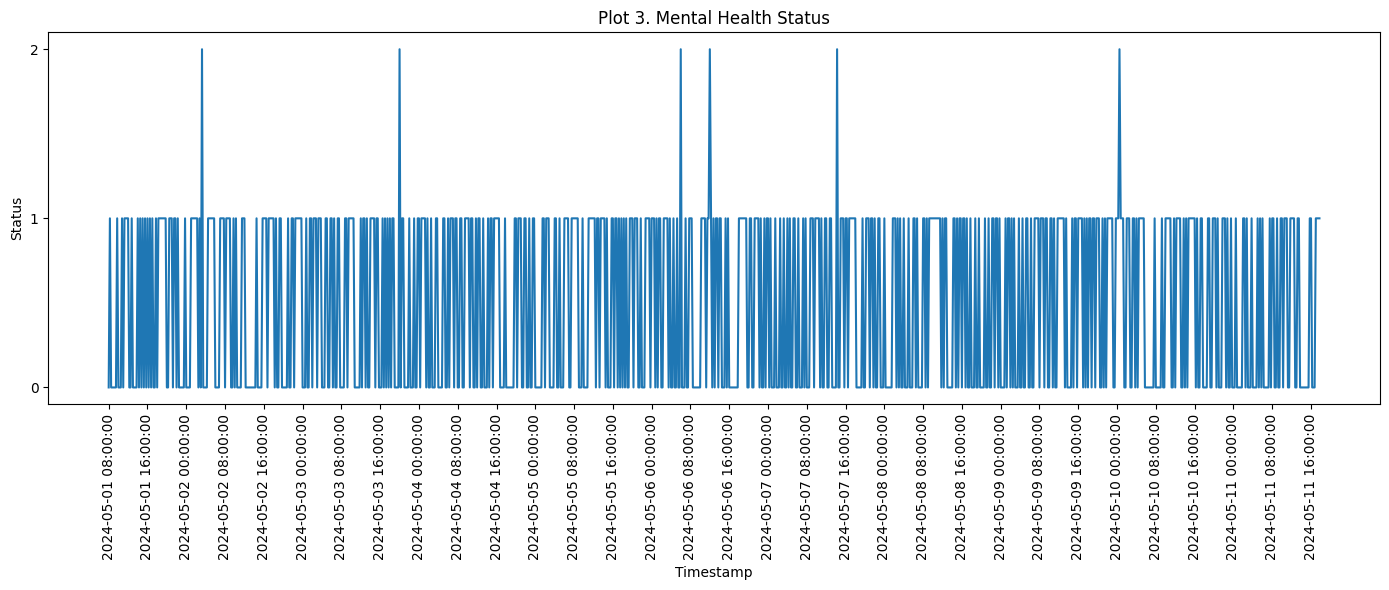

In [240]:
unique_y = sorted(plot_df['mental_health_status'].unique())

# Plot using string x-axis
plt.figure(figsize=(14, 6))
plt.plot(plot_df['timestamp'], plot_df['mental_health_status'])

plt.title("Plot 3. Mental Health Status")
plt.xlabel("Timestamp")
plt.ylabel("Status")
plt.xticks(ticks=plot_df['timestamp'][::32], labels=plot_df['timestamp'][::32], rotation=90)
plt.yticks(unique_y)

plt.tight_layout()
plt.show()

In [241]:
outlier_timestamps = plot_df[plot_df['mental_health_status'] == 2]['timestamp']
print('There are only', outlier_timestamps.count(), 'points out of', len(plot_df), 'where mental health == 2.')
print('Let\'s print them next to the 30 minutes of prior and following timestamps')
delta = pd.Timedelta(minutes=30)
mask = plot_df['timestamp'].apply(
    lambda ts: any((ts >= t - delta) and (ts <= t + delta) for t in outlier_timestamps)
)
plot_df[mask][['timestamp', 'mental_health_status']]

There are only 6 points out of 1000 where mental health == 2.
Let's print them next to the 30 minutes of prior and following timestamps


timestamp  mental_health_status
75  2024-05-02 02:45:00                     1
76  2024-05-02 03:00:00                     0
77  2024-05-02 03:15:00                     2
78  2024-05-02 03:30:00                     0
79  2024-05-02 03:45:00                     0
238 2024-05-03 19:30:00                     0
239 2024-05-03 19:45:00                     0
240 2024-05-03 20:00:00                     2
241 2024-05-03 20:15:00                     0
242 2024-05-03 20:30:00                     1
470 2024-05-06 05:30:00                     0
471 2024-05-06 05:45:00                     0
472 2024-05-06 06:00:00                     2
473 2024-05-06 06:15:00                     0
474 2024-05-06 06:30:00                     0
494 2024-05-06 11:30:00                     1
495 2024-05-06 11:45:00                     1
496 2024-05-06 12:00:00                     2
497 2024-05-06 12:15:00                     1
498 2024-05-06 12:30:00                     0
599 2024-05-07 13:45:00                     0
600 2024-05-07 14:00:00                     0
601 2024-05-07 14:15:00                     2
602 2024-05-07 14:30:00                     0
603 2024-05-07 14:45:00                     0
832 2024-05-10 00:00:00                     1
833 2024-05-10 00:15:00                     1
834 2024-05-10 00:30:00                     2
835 2024-05-10 00:45:00                     1
836 2024-05-10 01:00:00                     1

Once again, it’s unclear how the data was collected or stored, or whether there could have been an entry error — especially if the data comes from a device. However, based on some observations, there’s reason to suspect that the value '2' might actually be valid. Often, during the 30 minutes prior to a '2' episode and the 30 minutes following it, the mental_health_status is recorded as '0'. Could it really shift that quickly back and forth?

The only piece of evidence suggesting that '2' might not be an outlier after all is the stress level plot in Section 1.2. In that plot, the stress associated with mental_health_status == '2' clearly forms a distinct bell-shaped curve, far from the distributions of the other two categories. This could imply that extreme stress may cause mental health to deteriorate rapidly — supporting the idea that '2' is a legitimate class. 

Let's explore feature outliers and their relation to the target by plotting boxplots:

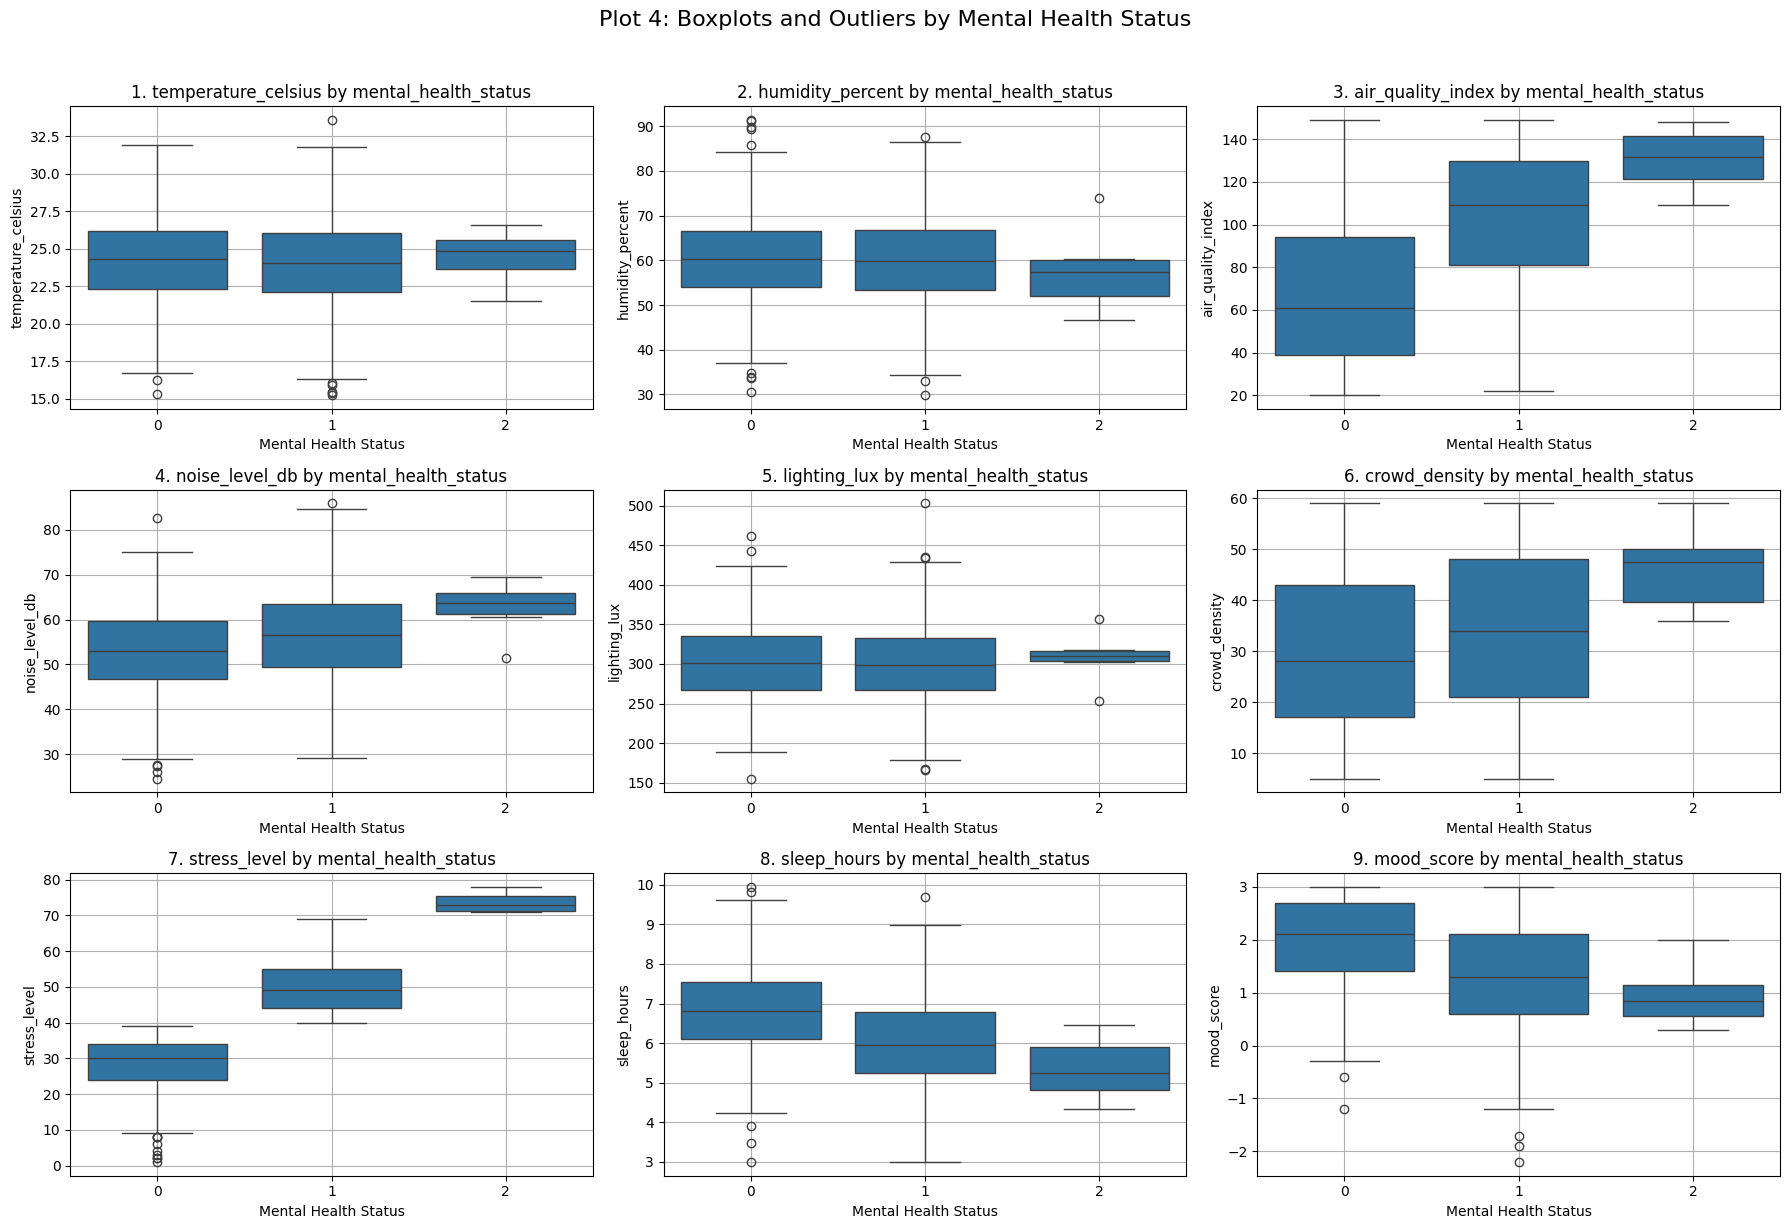

In [242]:
columns_to_plot = df.columns.drop(['location_id', 'timestamp', 'mental_health_status'])

# Set up subplot grid
n_cols = 3
n_rows = math.ceil(len(columns_to_plot) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    sns.boxplot(x='mental_health_status', y=col, data=plot_df, ax=ax)
    ax.set_title(f"{i+1}. {col} by mental_health_status")
    ax.set_xlabel("Mental Health Status")
    ax.set_ylabel(col)
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Plot 4: Boxplots and Outliers by Mental Health Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


We can observe that certain features (like stress_level or air_quality_index) vary significantly across different mental_health_status classes. Let’s focus on the group with mental_health_status == 2. Judging by the plots, it appears this could actually be a valid class rather than a data entry error.

However, there are only 6 data points labeled as class 2. This extremely small sample size means they could be statistical outliers, and the boxplots might be misleading. No model is likely to reliably predict this class (with this particular dataset), it may be more practical to treat these values as outliers.

From this point onward, I’ll assume that class 2 is a data entry anomaly. Instead of dropping these rows, which would create gaps in the timestamp sequence (potentially more harmful than keeping mild outliers). I will replace these values using the maximum of the two closest neighbors (i.e., the values 15 minutes before and after).

In [243]:
outlier_indices = plot_df[plot_df['mental_health_status'] == 2].index
for idx in outlier_indices:
    val_before = plot_df.loc[idx-1]['mental_health_status'] #if there were missing timepoints we should've handled this by time delta
    val_after  = plot_df.loc[idx+1]['mental_health_status'] #instead of idx-1 or idx+1
    plot_df.at[idx, 'mental_health_status'] = max(val_before, val_after)

Next, we'll visualize feature values over time, highlighting likely outliers based on the 1.5×IQR threshold.

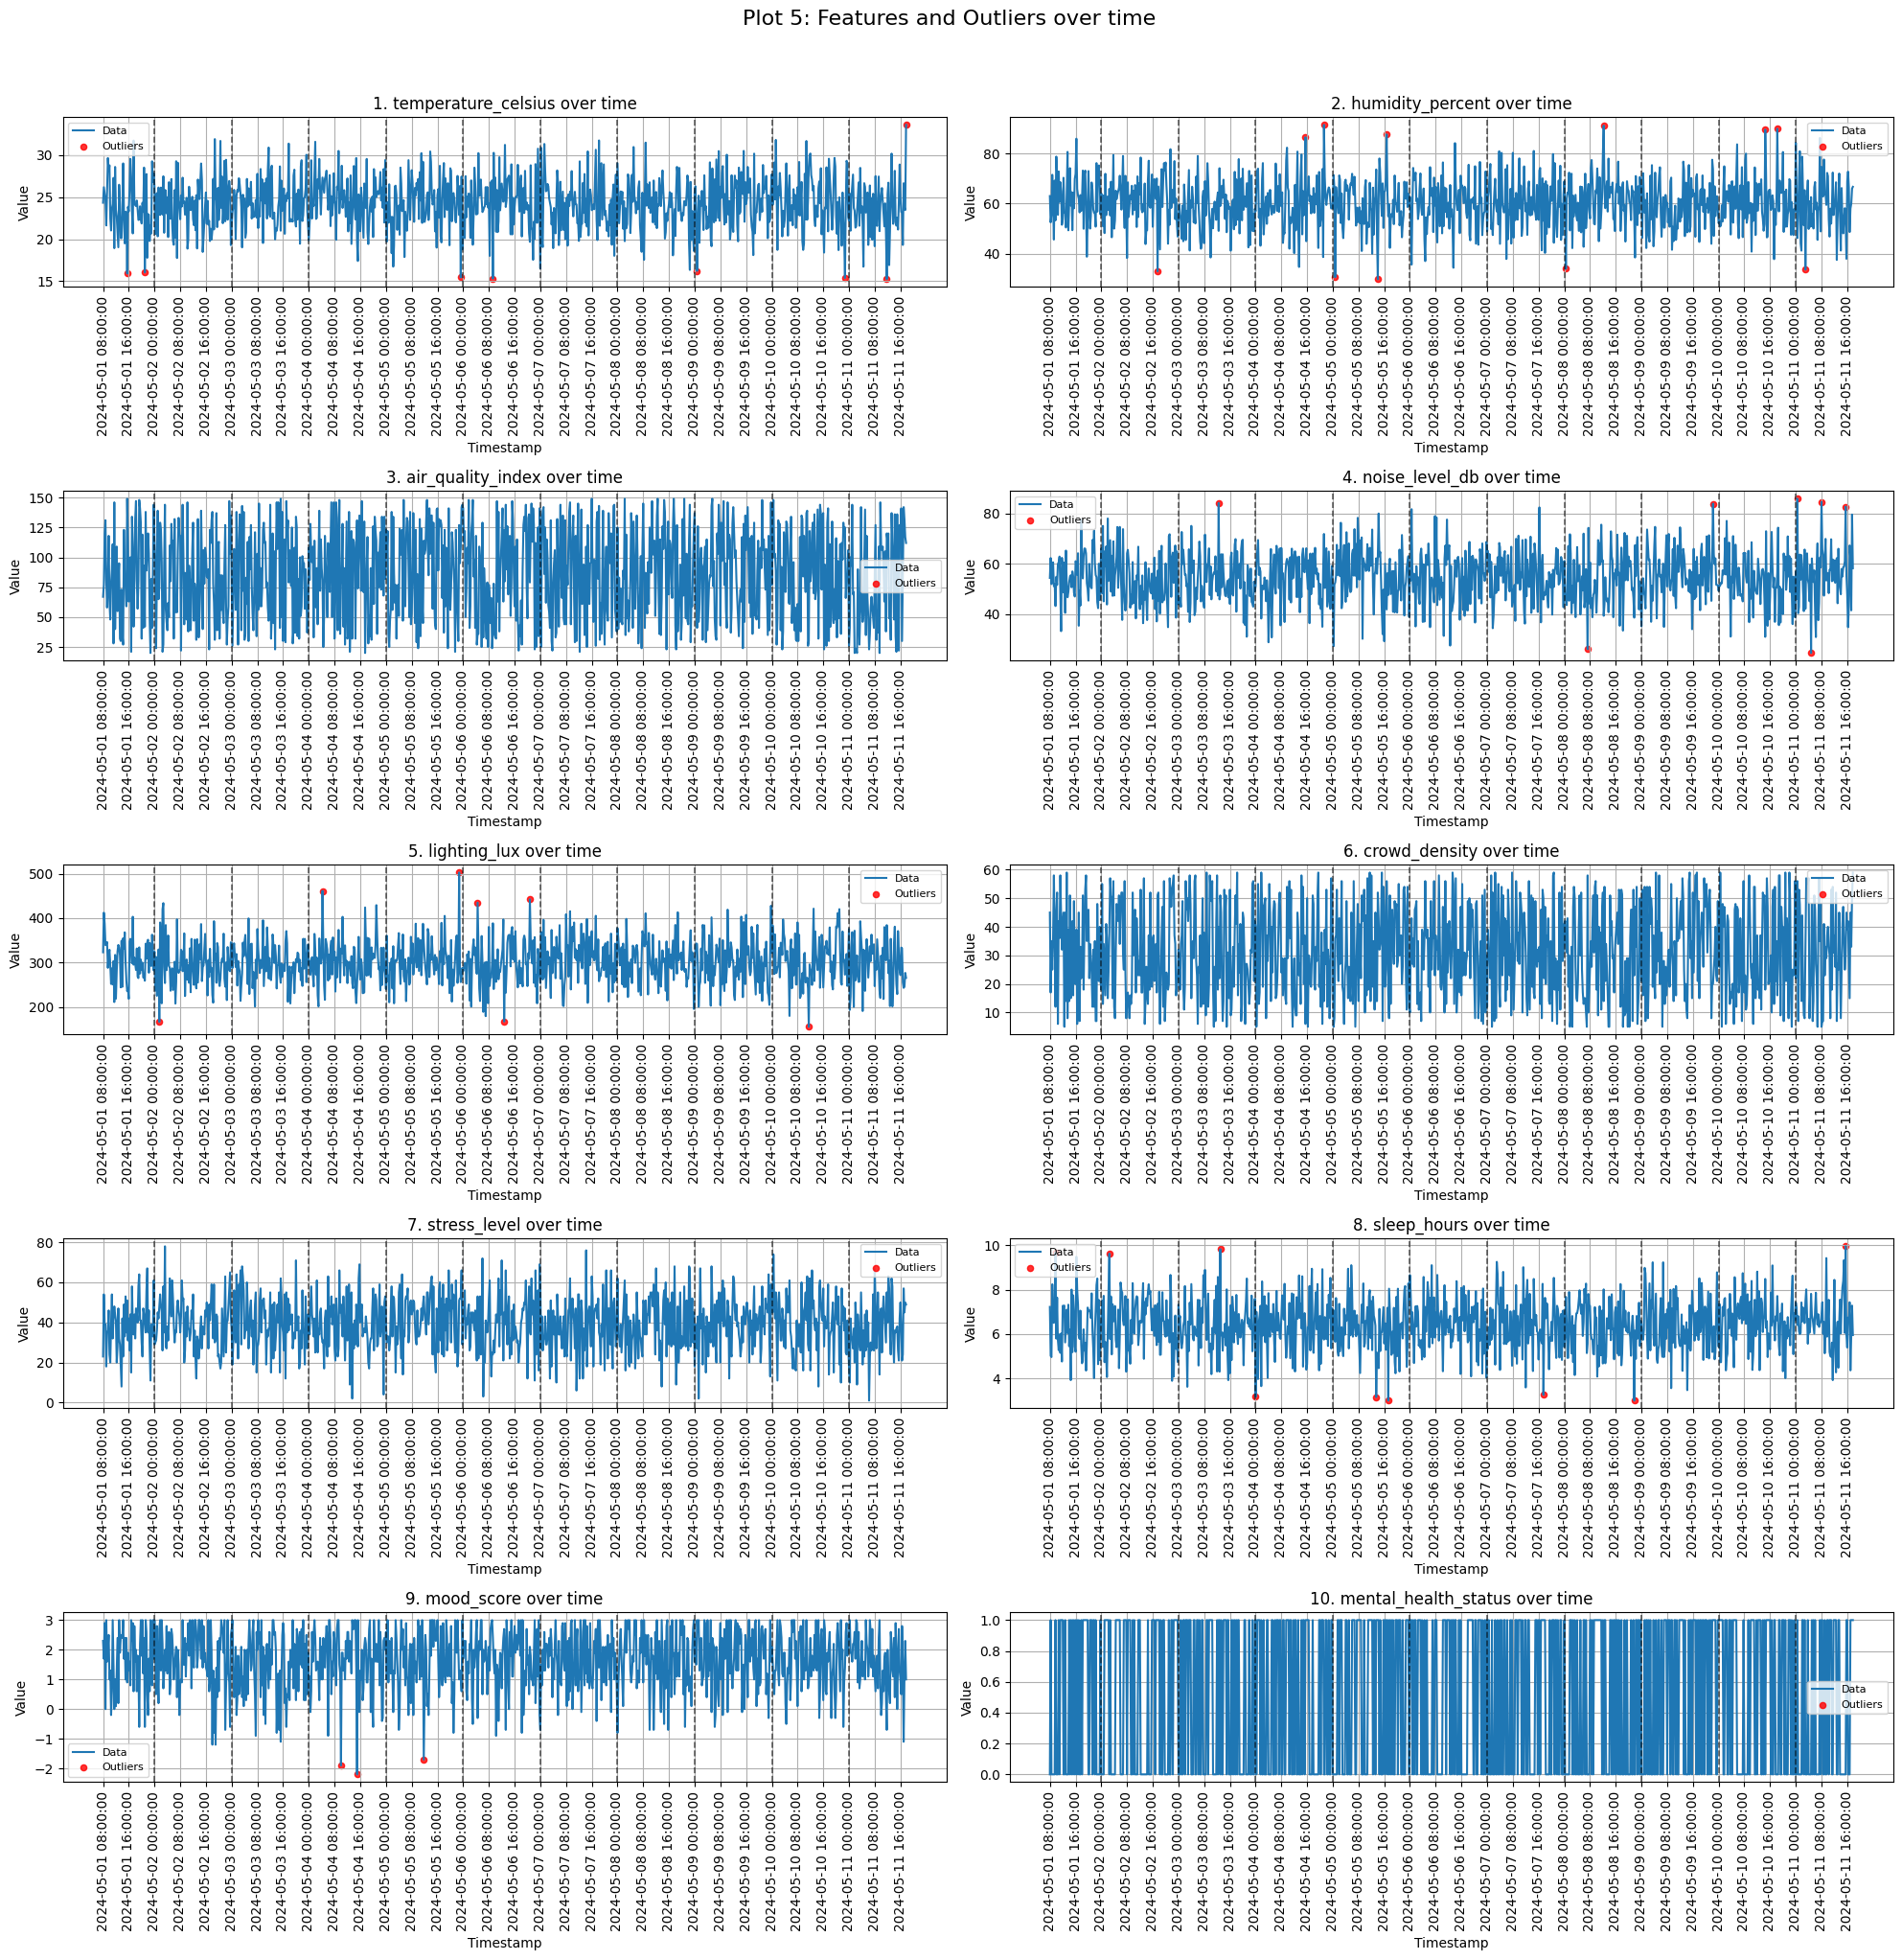

In [244]:
if plot_df.index.name != 'timestamp':
    plot_df = plot_df.set_index('timestamp')
columns_to_plot = df.columns.drop('timestamp').drop('location_id')

n_cols = 2
n_rows = math.ceil(len(columns_to_plot) / n_cols)

plt.figure(figsize=(n_cols * 10, n_rows * 4))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.plot(plot_df.index, plot_df[col], label='Data')

    q25 = plot_df[col].quantile(0.25)
    q75 = plot_df[col].quantile(0.75)
    iqr = q75 - q25
    lq = q25 - 1.5 * iqr
    uq = q75 + 1.5 * iqr
    outliers = (plot_df[col] < lq) | (plot_df[col] > uq)

    # Plot outliers as red dots
    plt.scatter(plot_df.index[outliers], plot_df[col][outliers],
                color='red', label='Outliers', s=20, alpha=0.8)
    midnights = plot_df.index[plot_df.index.time == pd.to_datetime("00:00:00").time()]
    for ts in midnights:
        plt.axvline(x=ts, color='black', linestyle='--', linewidth=1.2, alpha=0.6)

    plt.title(f"{i}. {col} over time")
    plt.ylabel('Value')
    plt.xlabel("Timestamp")
    plt.xticks(ticks=plot_df.index[::32], 
               labels=plot_df.index[::32], rotation=90)
    plt.legend(fontsize=8)
    plt.grid(True)

plt.suptitle('Plot 5: Features and Outliers over time', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

We need to be thoughtful when interpreting IQR-based outliers plotted alongside the data. If the data comes from a device, are sudden changes in the environment possible? Let’s assume the data is collected from a smartwatch and consider the noise_level feature. Could someone step into a loud environment and leave it within 15 minutes? Absolutely. The same goes for entering a bright or humid space (all of these are realistic scenarios).

So while the plots mark some values as outliers using the 1.5*IQR rule, even a quick visual inspection suggests they’re not that far off from the rest of the distribution and may reflect genuine environmental changes.

The only two features that truly stand out to me are mood_score, where the outliers stretch much farther from the core distribution, and sleep_hours, which I find difficult to interpret in this context.

Let’s take a closer look at one data point with a clear outlier and try to reason about its validity.

In [245]:
sh_outlier_timestamps = plot_df[plot_df['sleep_hours'] < 3.5].index
print('Let\'s print 1 sleep_hours outlier (id=256) next to the 90 minutes of prior and following timestamps: ')
delta = pd.Timedelta(minutes=90)
mask = [any((ts >= t - delta) and (ts <= t + delta) for t in sh_outlier_timestamps)
        for ts in plot_df.index]
cleaned_df_reset = plot_df.copy().reset_index()
cleaned_df_reset[mask][['timestamp', 'sleep_hours']].iloc[1:14]

Let's print 1 sleep_hours outlier (id=256) next to the 90 minutes of prior and following timestamps: 


timestamp  sleep_hours
251 2024-05-03 22:45:00         7.73
252 2024-05-03 23:00:00         5.22
253 2024-05-03 23:15:00         6.12
254 2024-05-03 23:30:00         6.35
255 2024-05-03 23:45:00         7.58
256 2024-05-04 00:00:00         3.17
257 2024-05-04 00:15:00         7.00
258 2024-05-04 00:30:00         6.07
259 2024-05-04 00:45:00         3.97
260 2024-05-04 01:00:00         6.53
261 2024-05-04 01:15:00         6.85
262 2024-05-04 01:30:00         7.27
400 2024-05-05 12:00:00         7.48

I'm finding it difficult to understand the meaning of the sleep_hours feature and what it actually represents. How can sleep hours be updated every 15 minutes? One possible assumption is that during sleep, this metric might accumulate — incrementing by 0 to 15 minutes at each timestamp — and during awake periods, it could decrease, almost like the green bars you see for Sims characters.

However, I don’t observe any such pattern in the data. The values don’t seem to increase steadily during sleep or decrease consistently when awake, which makes the interpretation of this feature unclear.

In [246]:
q25 = plot_df['mood_score'].quantile(0.25)
q75 = plot_df['mood_score'].quantile(0.75)
iqr = q75 - q25
lq = q25 - 1.5 * iqr
uq = q75 + 1.5 * iqr
outlier_mask = (plot_df['mood_score'] < lq) | (plot_df['mood_score'] > uq)
mc_outlier_timestamps = plot_df.index[outlier_mask]
print('Let\'s print mood_score outliers located at:', list(mc_outlier_timestamps) , 'next to the 90 minutes of prior and following timestamps: ')
delta = pd.Timedelta(minutes=90)
mask = [any((ts >= t - delta) and (ts <= t + delta) for t in mc_outlier_timestamps)
        for ts in plot_df.index]
cleaned_df_reset[mask][['timestamp', 'mood_score']]

Let's print mood_score outliers located at: [Timestamp('2024-05-04 10:00:00'), Timestamp('2024-05-04 15:00:00'), Timestamp('2024-05-05 11:45:00')] next to the 90 minutes of prior and following timestamps: 


timestamp  mood_score
290 2024-05-04 08:30:00         0.8
291 2024-05-04 08:45:00         2.7
292 2024-05-04 09:00:00         3.0
293 2024-05-04 09:15:00         3.0
294 2024-05-04 09:30:00         1.5
295 2024-05-04 09:45:00         1.2
296 2024-05-04 10:00:00        -1.9
297 2024-05-04 10:15:00         1.9
298 2024-05-04 10:30:00         1.9
299 2024-05-04 10:45:00         1.3
300 2024-05-04 11:00:00         1.7
301 2024-05-04 11:15:00         1.0
302 2024-05-04 11:30:00         2.3
310 2024-05-04 13:30:00         3.0
311 2024-05-04 13:45:00         2.7
312 2024-05-04 14:00:00         2.7
313 2024-05-04 14:15:00         3.0
314 2024-05-04 14:30:00         3.0
315 2024-05-04 14:45:00         1.4
316 2024-05-04 15:00:00        -2.2
317 2024-05-04 15:15:00         3.0
318 2024-05-04 15:30:00         0.4
319 2024-05-04 15:45:00        -0.1
320 2024-05-04 16:00:00         1.3
321 2024-05-04 16:15:00         1.0
322 2024-05-04 16:30:00         2.0
393 2024-05-05 10:15:00         2.7
394 2024-05-05 10:30:00         1.0
395 2024-05-05 10:45:00         2.8
396 2024-05-05 11:00:00         1.1
397 2024-05-05 11:15:00         3.0
398 2024-05-05 11:30:00         2.1
399 2024-05-05 11:45:00        -1.7
400 2024-05-05 12:00:00         0.5
401 2024-05-05 12:15:00         2.5
402 2024-05-05 12:30:00         2.0
403 2024-05-05 12:45:00         0.1
404 2024-05-05 13:00:00         0.5
405 2024-05-05 13:15:00        -0.2

Based on the observed patterns, it is reasonable to conclude that these values are likely outliers caused by erroneous negation — potentially due to a data entry or processing error. Therefore, it would be appropriate to correct them by multiplying the affected values by -1.

In [247]:
for ts in mc_outlier_timestamps:
    idx = plot_df.index.get_loc(ts)
    val_before  = plot_df.iloc[idx-1]['mood_score'] #if there were missing timepoints we should've handled this by time delta
    val_after   = plot_df.iloc[idx+1]['mood_score'] #instead of idx-1 or idx+1
    val_current = plot_df.iloc[idx]['mood_score'] 
    neighbor_sign = np.sign(val_before + val_after)
    if min(abs(val_after), abs(val_before)) <= abs(val_current) <= max(abs(val_after), abs(val_before)):
        if np.sign(val_current) != neighbor_sign and neighbor_sign != 0:
            plot_df.iloc[idx, plot_df.columns.get_loc('mood_score')] *= -1

Given the limited domain knowledge and after further examination of additional features not included in this notebook, it appears that the remaining unusual values may not be true outliers. Instead, they could represent natural variability or sensor noise — which is common in IoT-generated data. Therefore, rather than aggressively filtering or correcting these values, it may be more appropriate to select a modeling approach that is inherently robust to outliers and sudden spikes.

# 2. Seasonality Analysis
## 2.1 Visual Check

Plot 5, which depicts outliers over time, shows each feature plotted against its corresponding timestamp. However, it’s not particularly easy to identify meaningful temporal patterns through direct visual inspection. To address this, I re-plotted the data by grouping it into 5-hour intervals — a timeframe chosen empirically to improve interpretability.

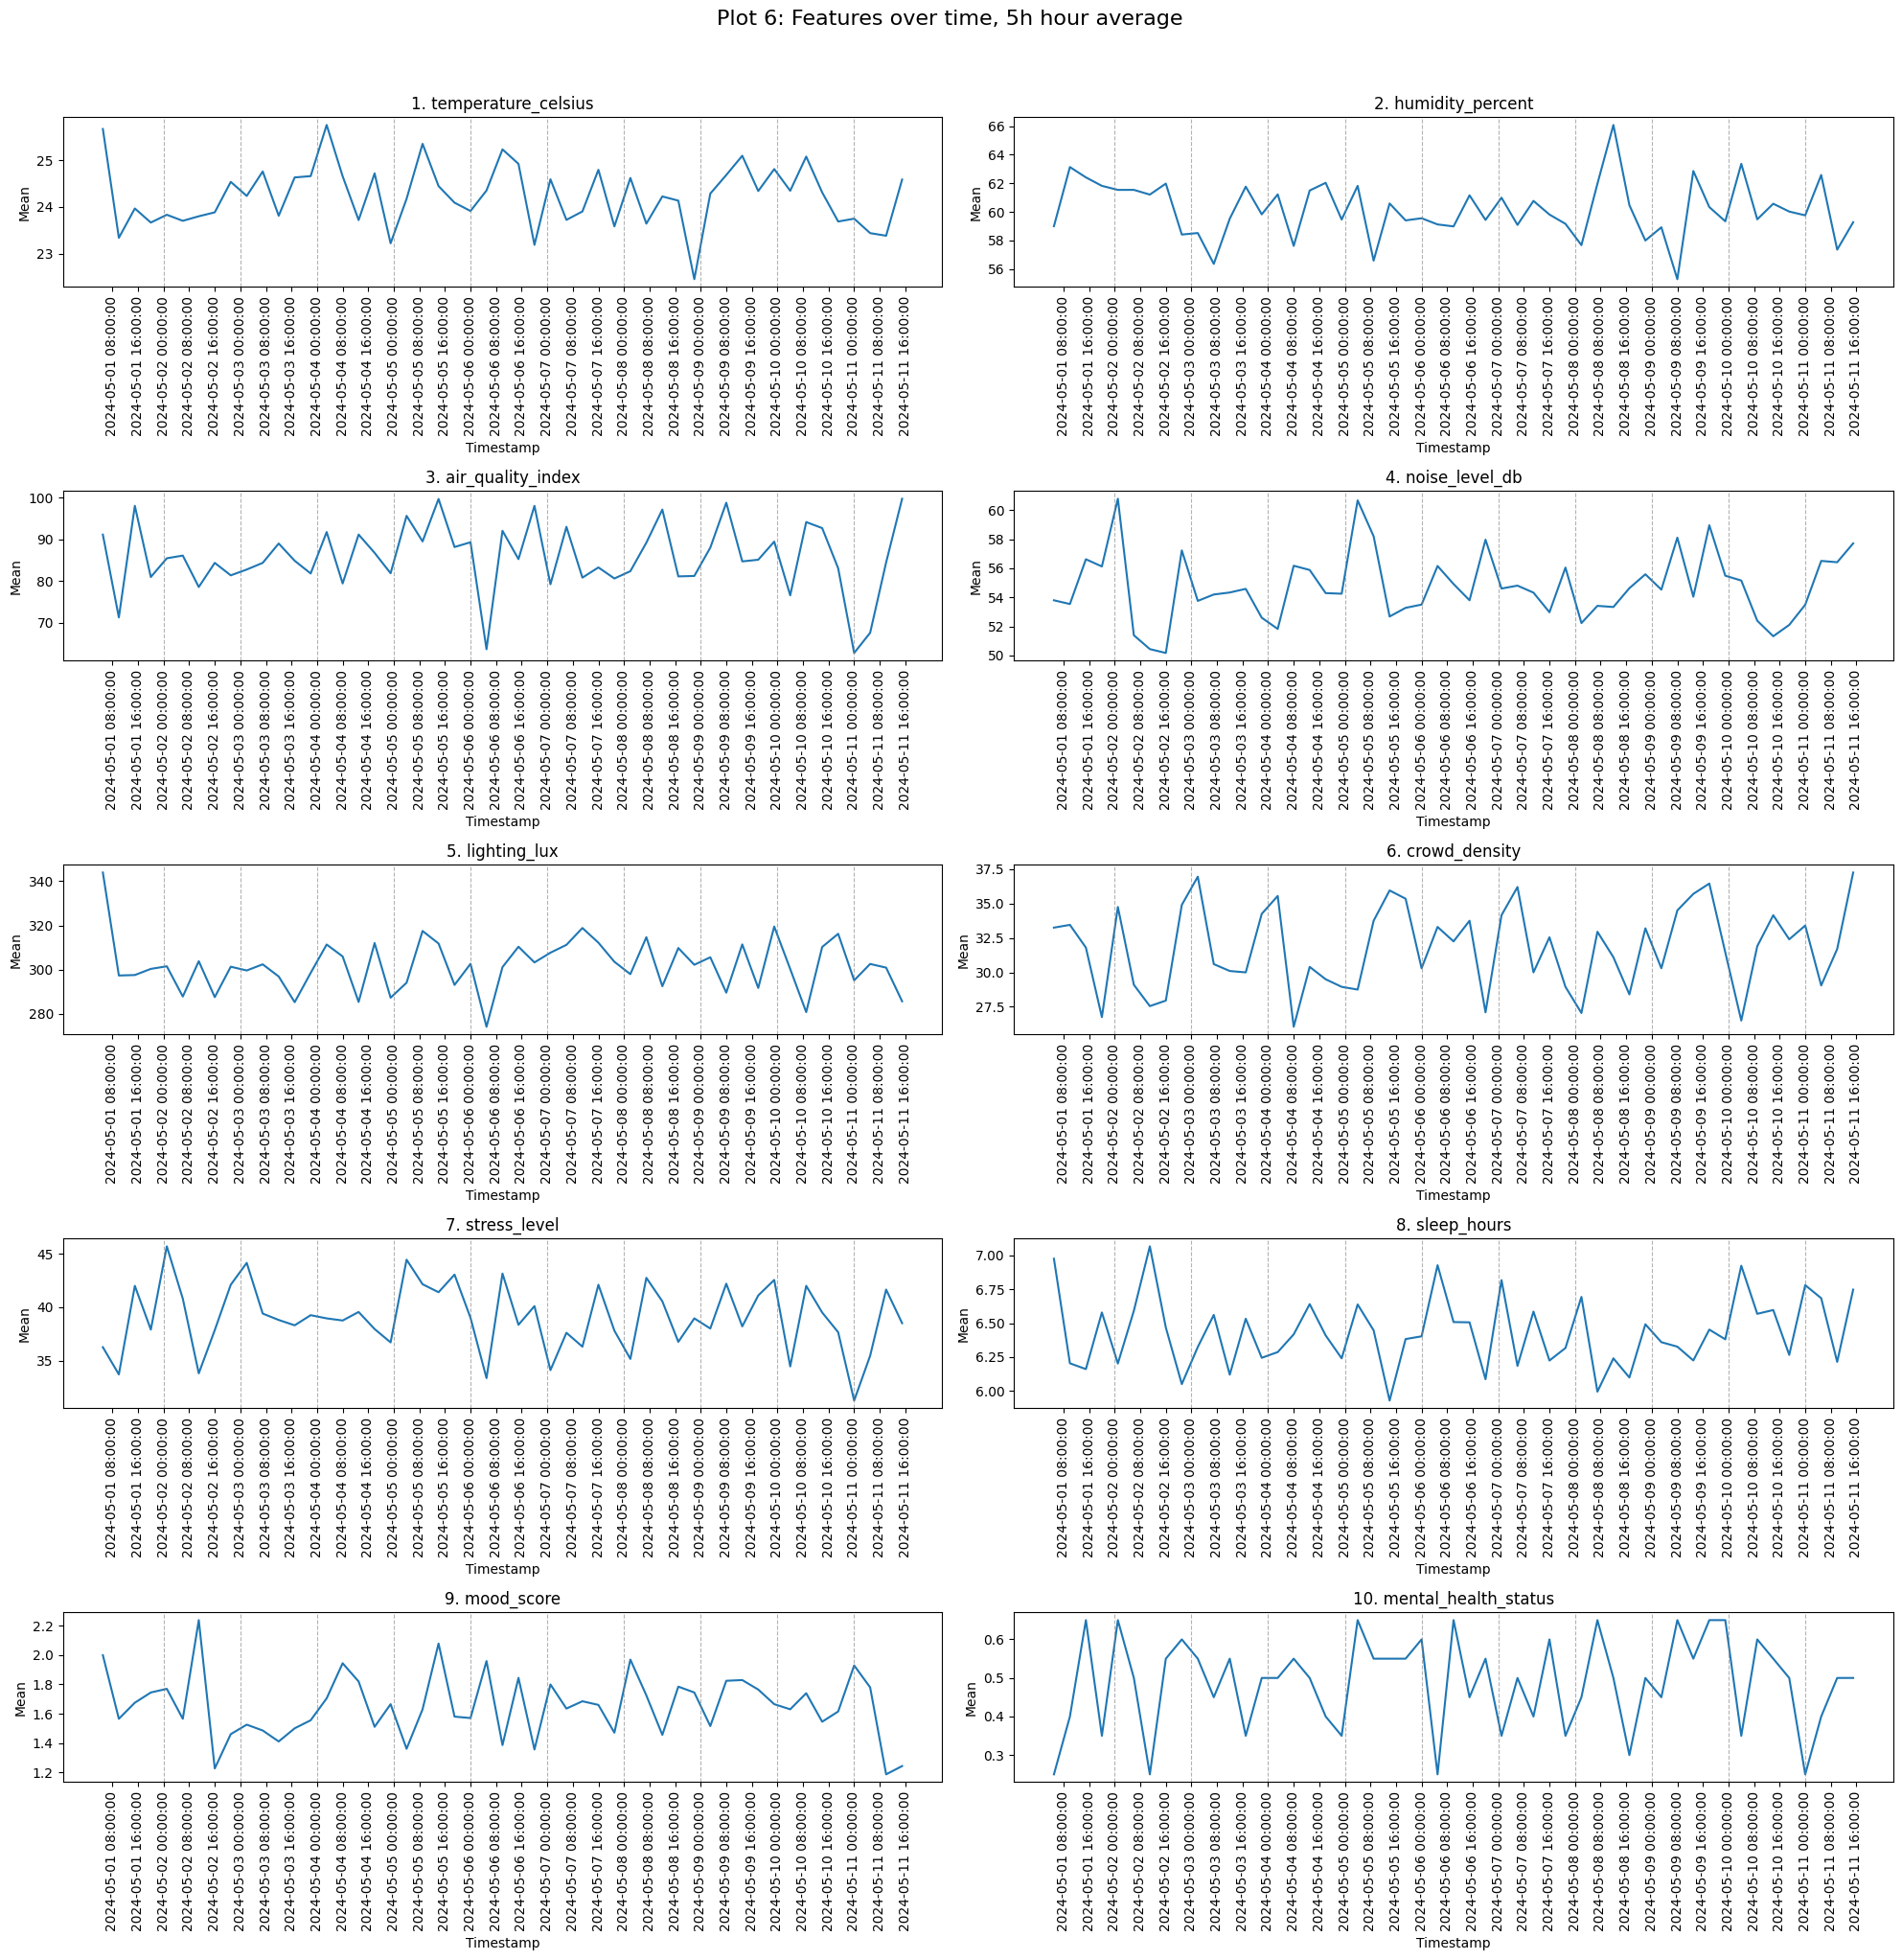

In [249]:
n_cols = 2
n_rows = math.ceil(len(columns_to_plot) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 4), sharex=False)
axes = axes.flatten()
period = '5h'
if plot_df.index.name != 'timestamp':
    plot_df = plot_df.set_index('timestamp')
for i, col in enumerate(columns_to_plot):
    rolling_series = plot_df[col].resample(period).mean()

    ax = axes[i]
    ax.plot(rolling_series)
    midnights = plot_df.index[plot_df.index.time == pd.to_datetime("00:00:00").time()]
    for ts in midnights:
        ax.axvline(x=ts, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.set_title(f"{i+1}. {col}")
    ax.set_ylabel("Mean")
    ax.set_xlabel("Timestamp")

    tick_locs = plot_df.index[::32]
    tick_labels = plot_df.index[::32]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Plot 6: Features over time, {period} hour average', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

We converted the data granularity from 15-minute intervals to 5-hour intervals. While analyzing the aggregated data, I noticed an interesting pattern and verified it with a quick Google search: May 2, 2024, was a Thursday; May 3, a Friday; and May 4, a Saturday.

What led me to this realization was the behavior of the crowd and sleep_hours features. On those dates, crowd levels were unusually high around midnight, while sleep_hours appeared lower than on other days - potentially indicating late-night activity. While this could be coincidental, it might also suggest that the individual was out late on those specific days.

Additionally, stress_level and noise_level both spiked on May 2nd, and the mental_health_status was recorded as '1' that night.
This observation suggests we could benefit from engineering a new feature, such as is_weekend, to help capture behavioral shifts associated with weekends or social activity.

Overall, adjusting the time granularity proved helpful in revealing clearer temporal patterns. To further explore this, let’s plot mental_health_status and sleep_hours together to examine how their trends often appear inversely related.

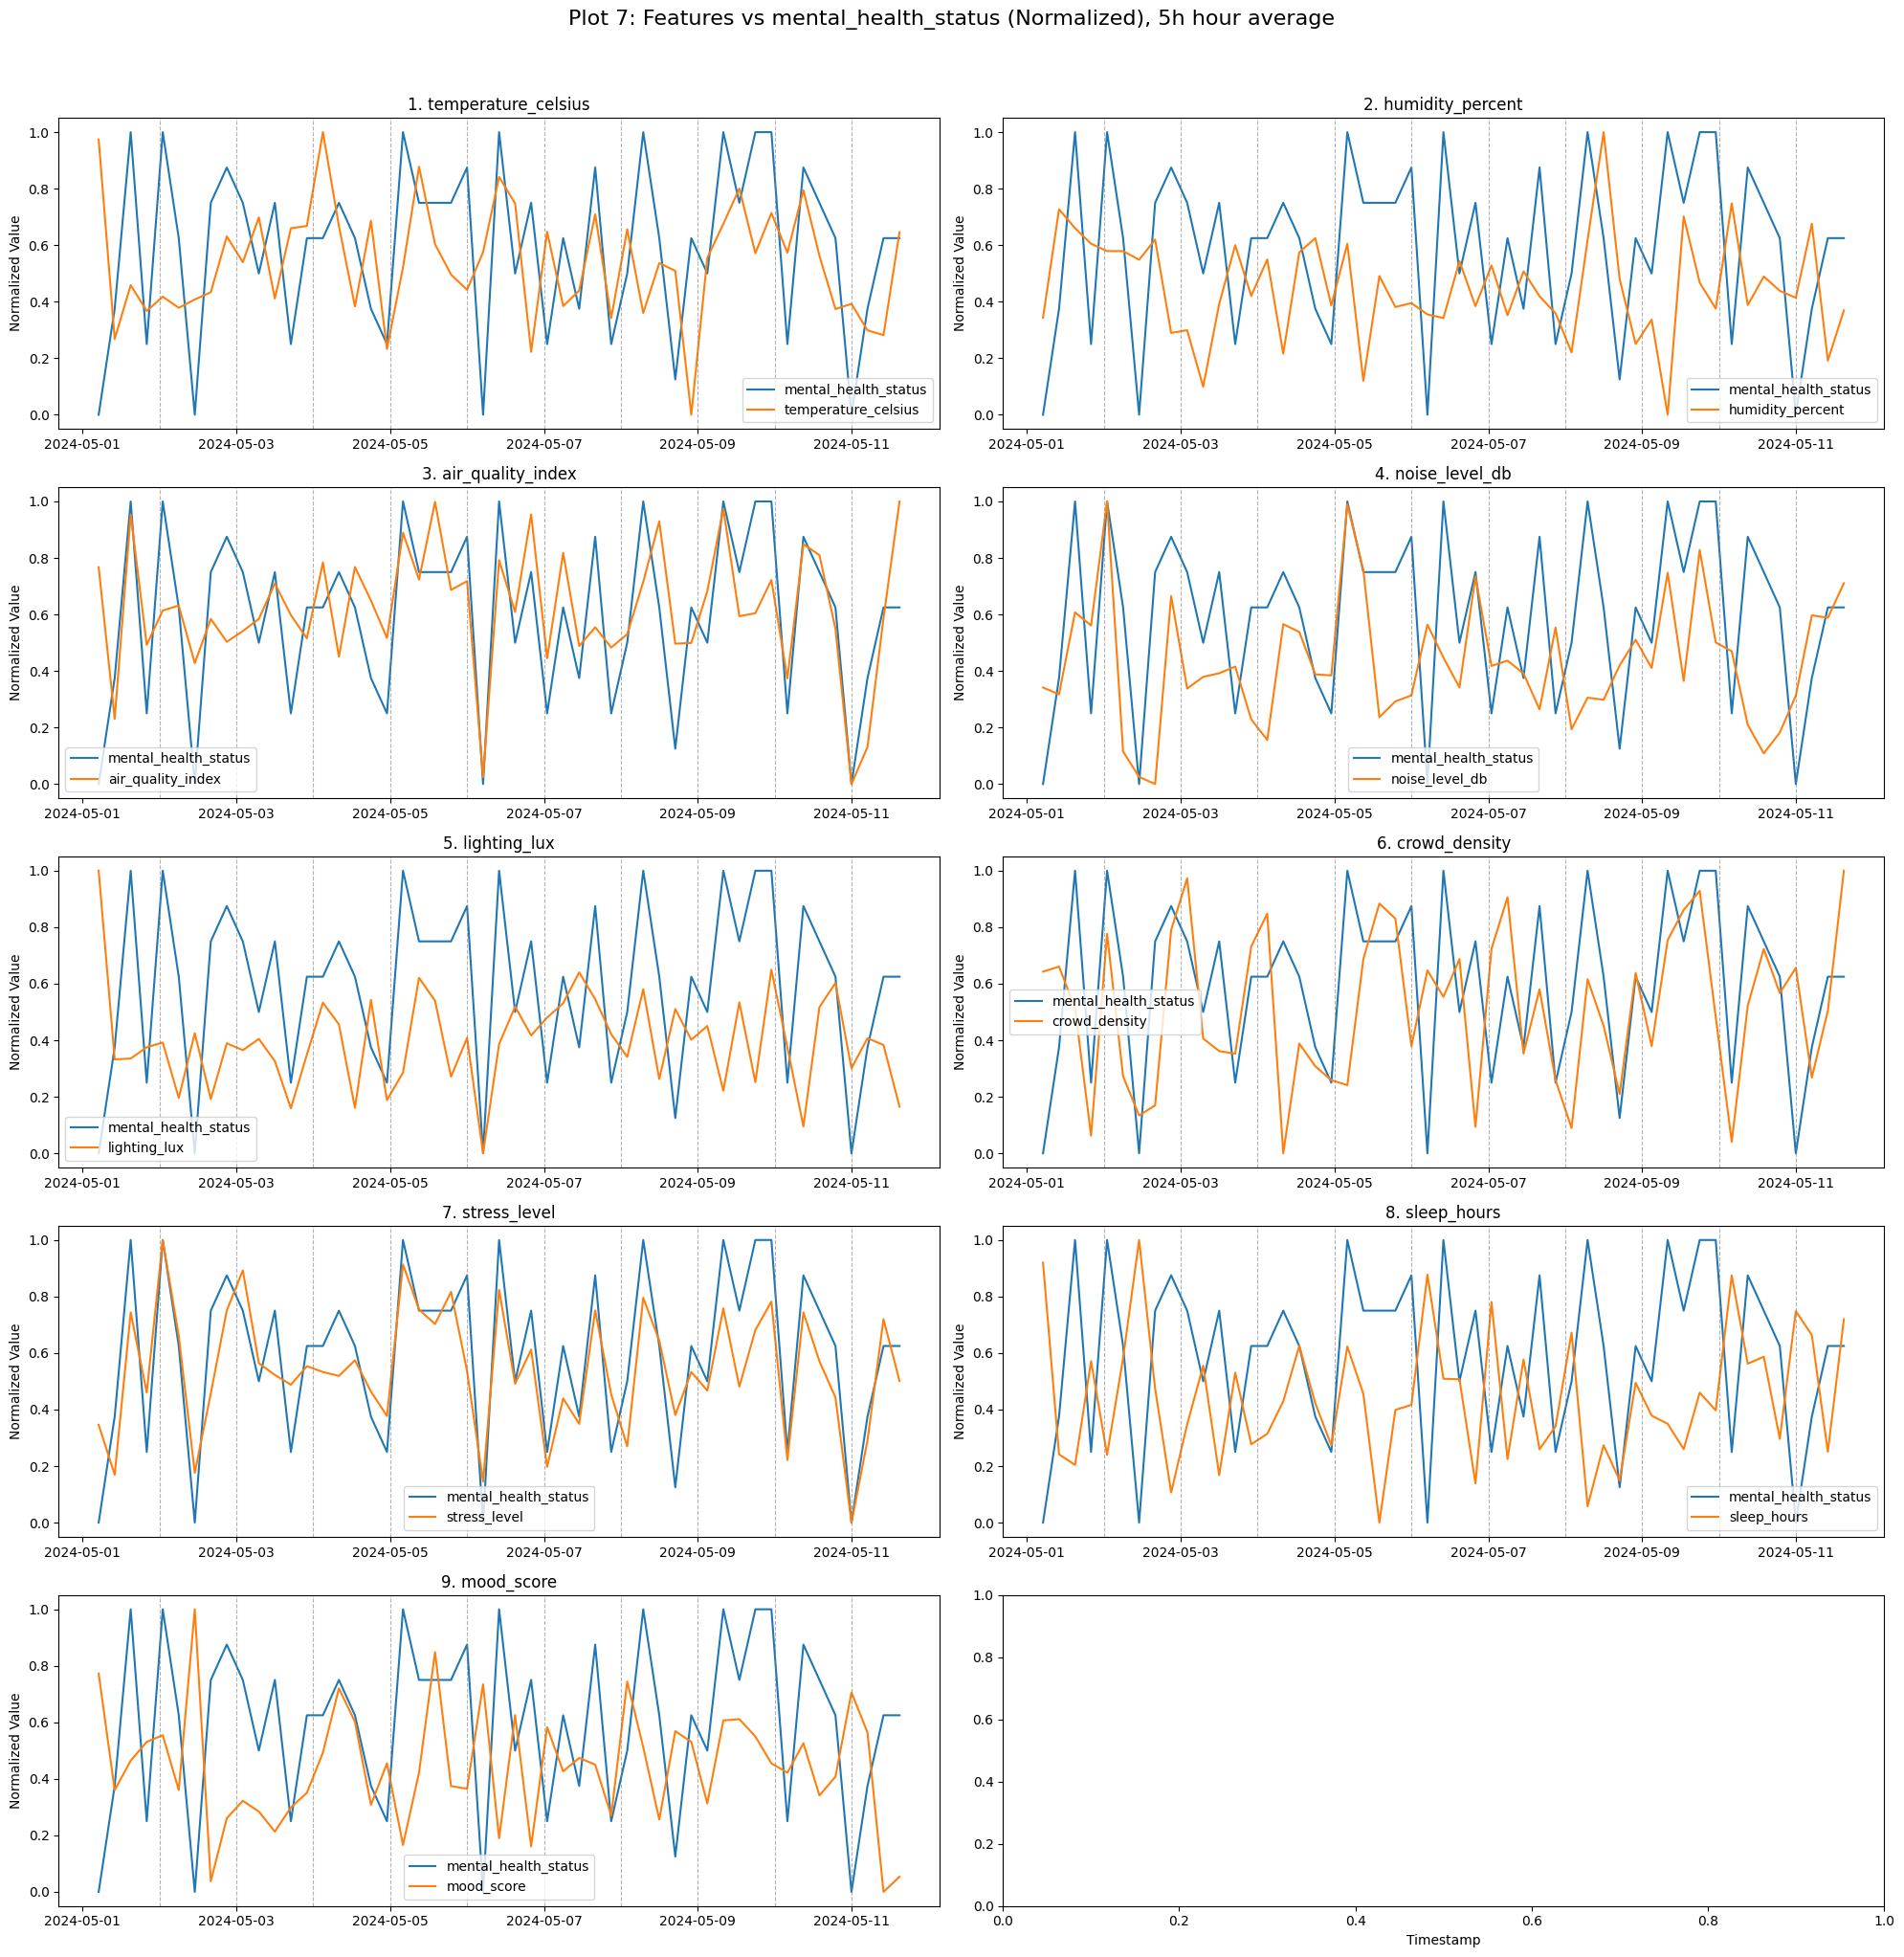

In [252]:
columns_to_plot = df.columns.drop(['timestamp', 'location_id', 'mental_health_status'])
period = '5h'
n_cols = 2
n_rows = math.ceil(len(columns_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 4), sharex=False)
axes = axes.flatten()

if len(columns_to_plot) == 1:
    axes = [axes]

midnights = plot_df.index[plot_df.index.time == pd.to_datetime("00:00:00").time()]
for i, (ax, col) in enumerate(zip(axes, columns_to_plot), start=1):
    pair_df = plot_df[['mental_health_status', col]].resample(period).mean()
    normalized = (pair_df - pair_df.min()) / (pair_df.max() - pair_df.min())

    ax.plot(normalized.index, normalized['mental_health_status'], label='mental_health_status')
    ax.plot(normalized.index, normalized[col], label=col)

    for ts in midnights:
        ax.axvline(x=ts, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

    ax.set_title(f"{i}. {col}")
    ax.set_ylabel("Normalized Value")
    ax.legend()

axes[-1].set_xlabel("Timestamp")

plt.suptitle(f'Plot 7: Features vs mental_health_status (Normalized), {period} hour average', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The plots above are identical to the averaged plots from the previous section, with one key difference: the data has been normalized on the y-axis using Z-scores. This normalization allows for clearer visual comparison of each feature against the target variable.

I’d like to highlight three plots that, in my opinion, exhibit a strong and visually obvious correlation with mental_health_status:
1. mental_health_status vs. stress_level (Subplot 7): These two lines are nearly identical, indicating a very strong positive correlation.
2. mental_health_status vs. sleep_hours (Subplot 8): Their trends are almost always inversely related — an increase in one typically corresponds to a decrease in the other.
3. mental_health_status vs. air_quality_index (Subplot 3): These two variables also show a consistent trend. Assuming a higher air_quality_index value represents worse air quality, this would suggest that poor air quality is associated with poorer mental health.

Some other features may show weaker or less obvious relationships with the target. For instance, crowd_density and temperature might be correlated, but it’s difficult to draw firm conclusions without further statistical analysis. At this stage, we’re primarily examining whether the trends in each feature align with changes in the target over time, and for most variables, visual inspection alone doesn’t yield much more than that.

As a next step, let’s quickly check whether any features exhibit linear correlation with mental_health_status.

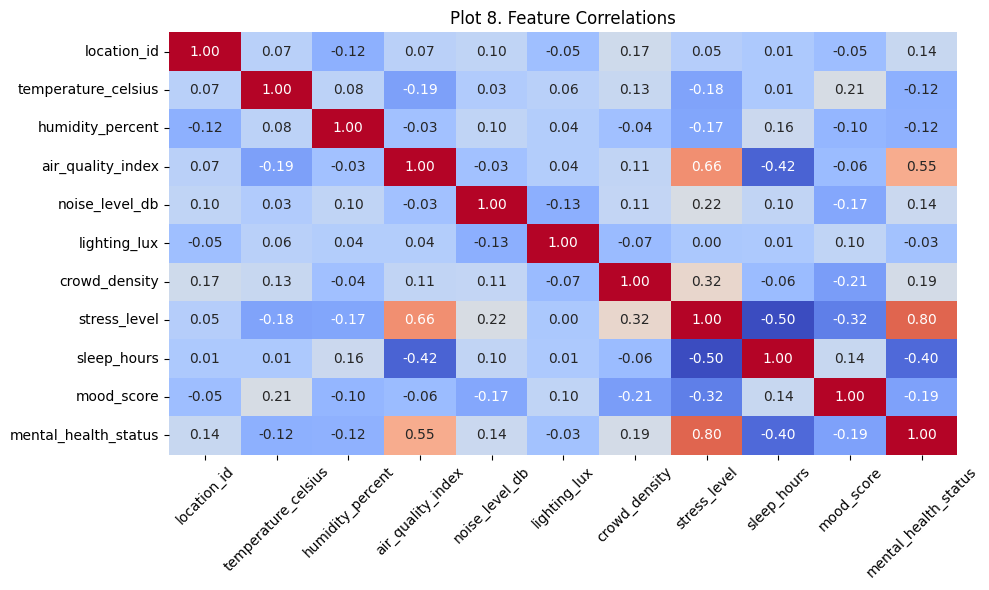

In [253]:
plot_df['time_of_day'] = plot_df.index.time 
avg_by_time = plot_df.groupby('time_of_day').mean(numeric_only=True)
corr_matrix = avg_by_time.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Plot 8. Feature Correlations')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The correlation plot confirms the patterns observed earlier. Features with lower correlation coefficients may still exhibit non-linear relationships with the target variable, which linear correlation metrics (like Pearson's r) may fail to capture. This will be taken into consideration later when selecting the appropriate model, for example, tree-based models are well-suited to handling non-linear dependencies.

At the same time, several features show strong linear correlations with the target and with each other. For instance, stress_level and mental_health_status exhibit an 80% positive correlation, suggesting that increases in one are strongly associated with increases in the other.

Another notable relationship is between sleep_hours and air_quality_index: approximately 42% of the variation in sleep_hours appears to be explained by changes in air_quality_index. According to previous observations, a higher air_quality_index value corresponds to poorer air quality, which may negatively impact sleep duration.

## 2.2 Seasonal Decomposition
### 2.2.1 Autocorrelation Function (ACF)

We will now dive deeper into seasonal analysis, which may help us engineer new time-based (seasonal) features. As a starting point, we'll use the Autocorrelation Function (ACF) to examine whether rolling time averages (temporal memory) influence the current values of key features.

For example, does the average stress level over the past 60 minutes have an effect on the current stress reading? This is an important question to explore, as it likely reflects how human behavior and physiological states evolve over time.

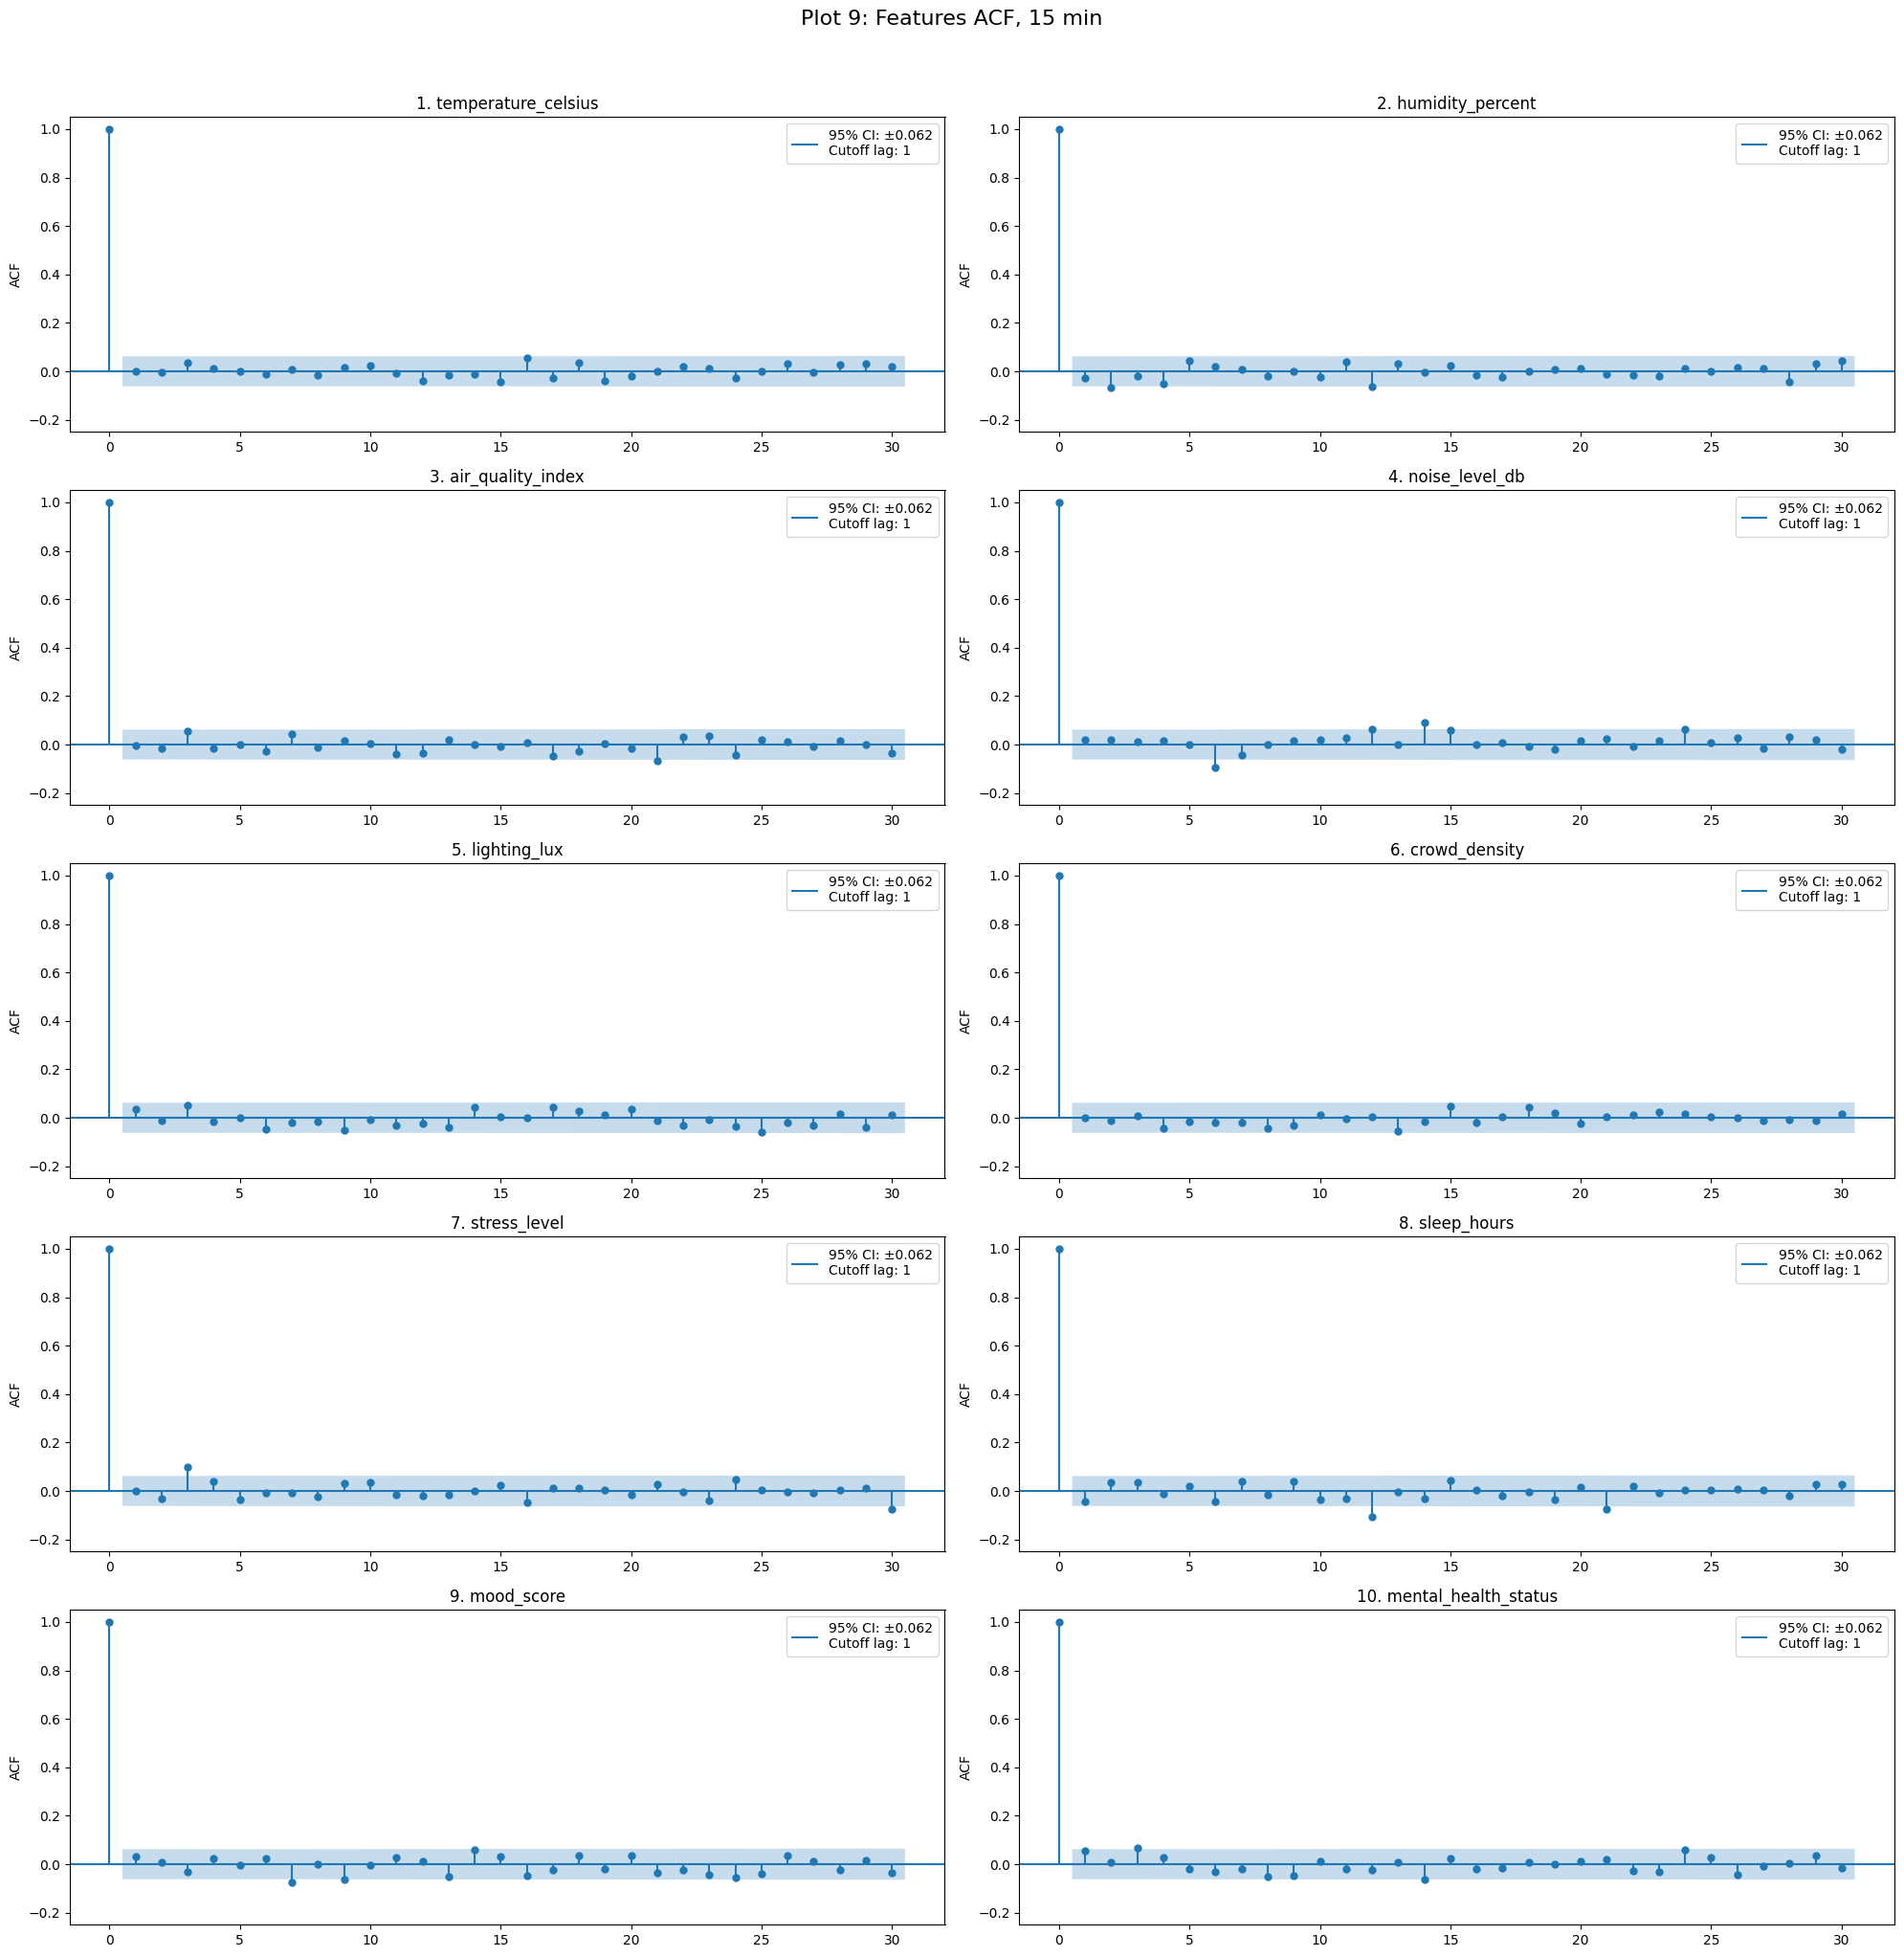

In [256]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 4), sharex=False)
columns_to_plot = df.columns.drop(['timestamp', 'location_id'])

axes = axes.flatten()
for i, col in enumerate(columns_to_plot):

    ax = axes[i]
    acf_vals = acf(plot_df[col].dropna(), nlags=48)
    threshold = 1.96 / (np.sqrt(len(plot_df[col].dropna()))) # == 95% CI
    cutoff_lag = next((i for i, v in enumerate(acf_vals) if abs(v) < threshold), 4)
    plot_acf(plot_df[col], ax=ax, alpha = 0.05)
    ax.set_title(f"{i+1}. {col}")
    ax.set_ylabel("ACF")
    legend_text = f"95% CI: ±{threshold:.3f}\nCutoff lag: {cutoff_lag}"
    ax.legend([legend_text], loc="upper right")
    ax.set_ylim(-0.25, 1.05)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Plot 9: Features ACF, 15 min', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The plots above suggest that there is no clear moving average effect on the features — in other words, none of the features appear to exhibit strong temporal "memory" that influences their current values.

However, given the high frequency of our data (15-minute intervals) and the fact that we're only examining the first 30 lags (equivalent to 7 hours and 30 minutes), it’s possible that we’re missing broader temporal dependencies.

To explore this further, let's re-plot the same ACFs using data grouped at an hourly level to see if a more general memory effect becomes visible over longer time spans.

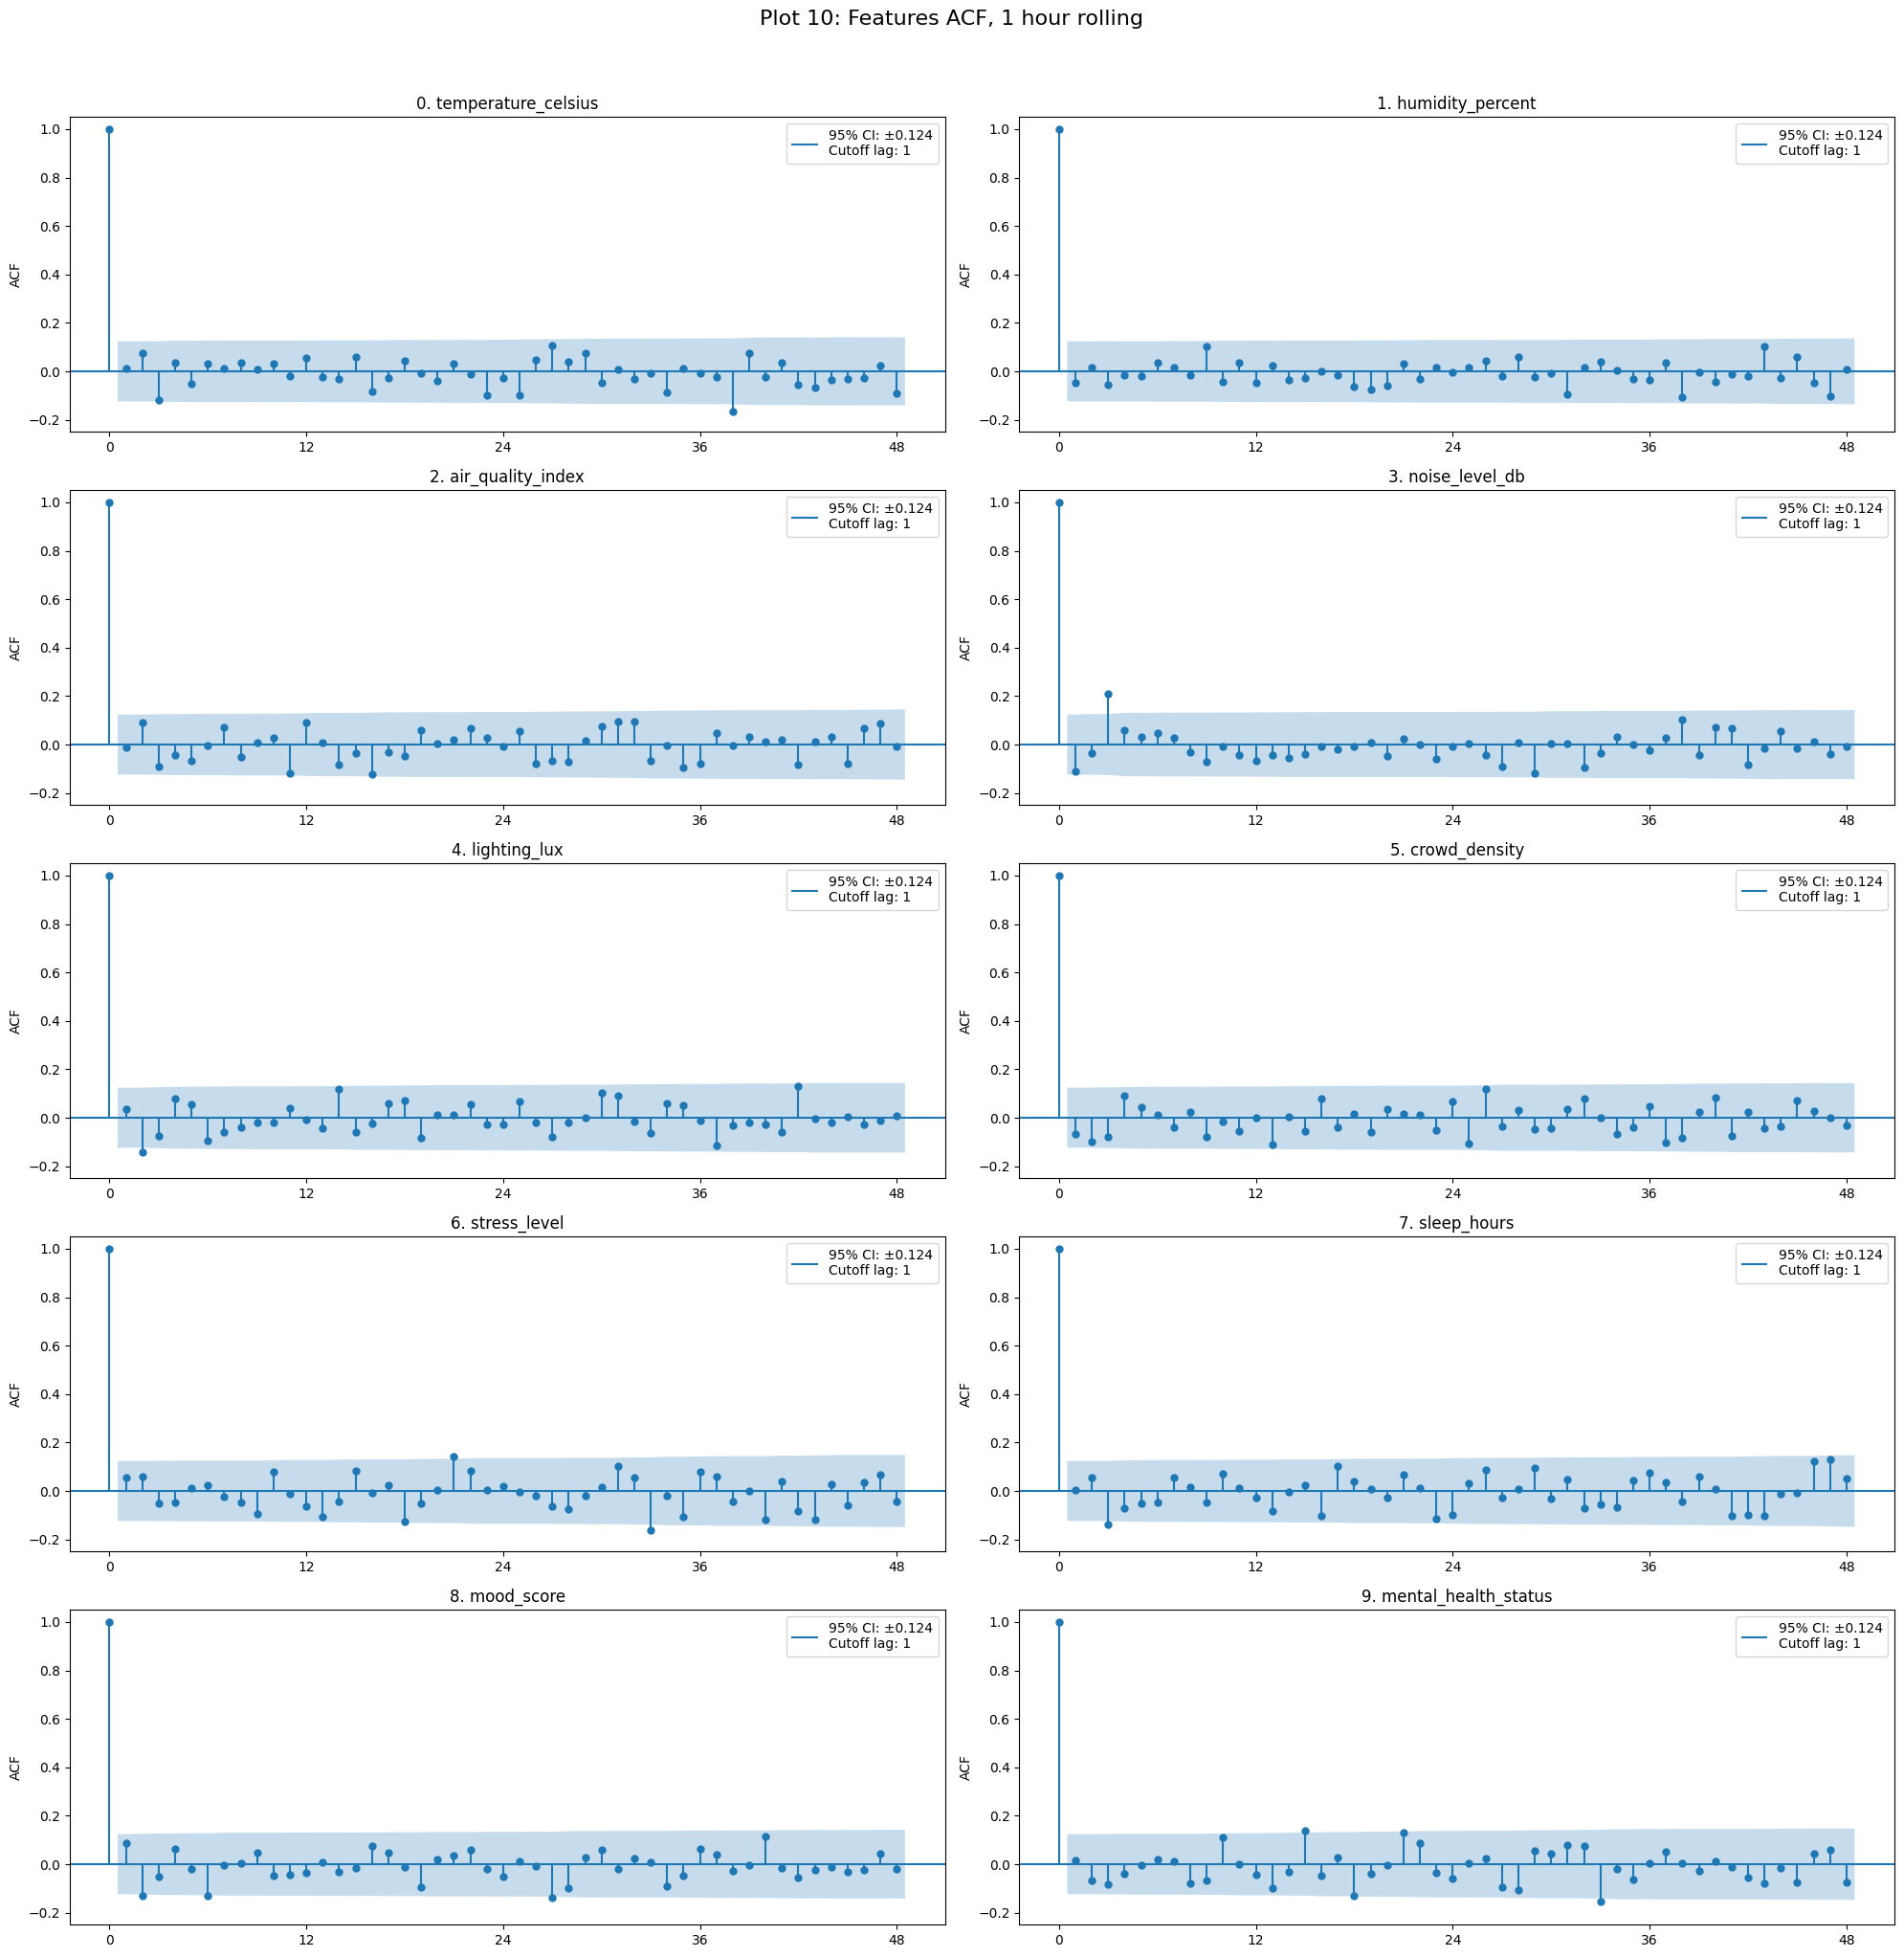

In [258]:
hourly_df = plot_df.drop(columns=['time_of_day']).resample('1h').mean()
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 4), sharex=False)
axes = axes.flatten()
for i, col in enumerate(columns_to_plot):

    ax = axes[i]
    acf_vals = acf(hourly_df[col].dropna(), nlags=48)
    threshold = 1.96 / (np.sqrt(len(hourly_df[col].dropna()))) # == 95% CI
    cutoff_lag = next((i for i, v in enumerate(acf_vals) if abs(v) < threshold), 4)
    plot_acf(hourly_df[col], ax=ax, alpha = 0.05, lags=48)
    ax.set_title(f"{i}. {col}")
    ax.set_ylabel("ACF")
    legend_text = f"95% CI: ±{threshold:.3f}\nCutoff lag: {cutoff_lag}"
    ax.legend([legend_text], loc="upper right")
    ax.set_ylim(-0.25, 1.05)
    ax.set_xticks(list(range(0, 49, 12)))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Plot 10: Features ACF, 1 hour rolling', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Even after resampling the data at an hourly level, no clear temporal memory or rolling average pattern emerges. While a few lags extend slightly beyond the confidence interval (CI), these occurrences are isolated and not immediate. Given that the ACF reflects autocorrelation over a rolling window, these minor deviations are not strong enough to suggest meaningful temporal dependence. As such, there is limited actionable insight to be drawn from these observations.

### 2.2.2 Partial Autocorrelation Function (PACF)
Next, we will explore the Partial Autocorrelation Function (PACF), which differs from the ACF in that it measures the direct effect of a given lag on the current value, after removing the influence of intermediate lags. Unlike ACF, PACF does not reflect cumulative or rolling memory, instead, it isolates the unique contribution of each individual lag.

For example, a high stress_level reading might be directly correlated with another high value one hour later perhaps due to a delayed physiological response (hypothetically, such as the effect of stress-related brain chemicals). This makes PACF particularly valuable for identifying delayed correlations, not just immediate ones following lag 0.

To capture this, we’ll highlight significant lags directly in the plot legends — not just the initial cutoff point (as we did with ACF, where we mainly focused on how many early lags extended beyond the confidence interval). This time, we’re also interested in delayed dependencies, for example, lags occurring 1 hour or even 24 hours later.

We will examine PACF using both 15-minute and 1-hour aggregated versions of the data to capture relationships across different temporal resolutions.

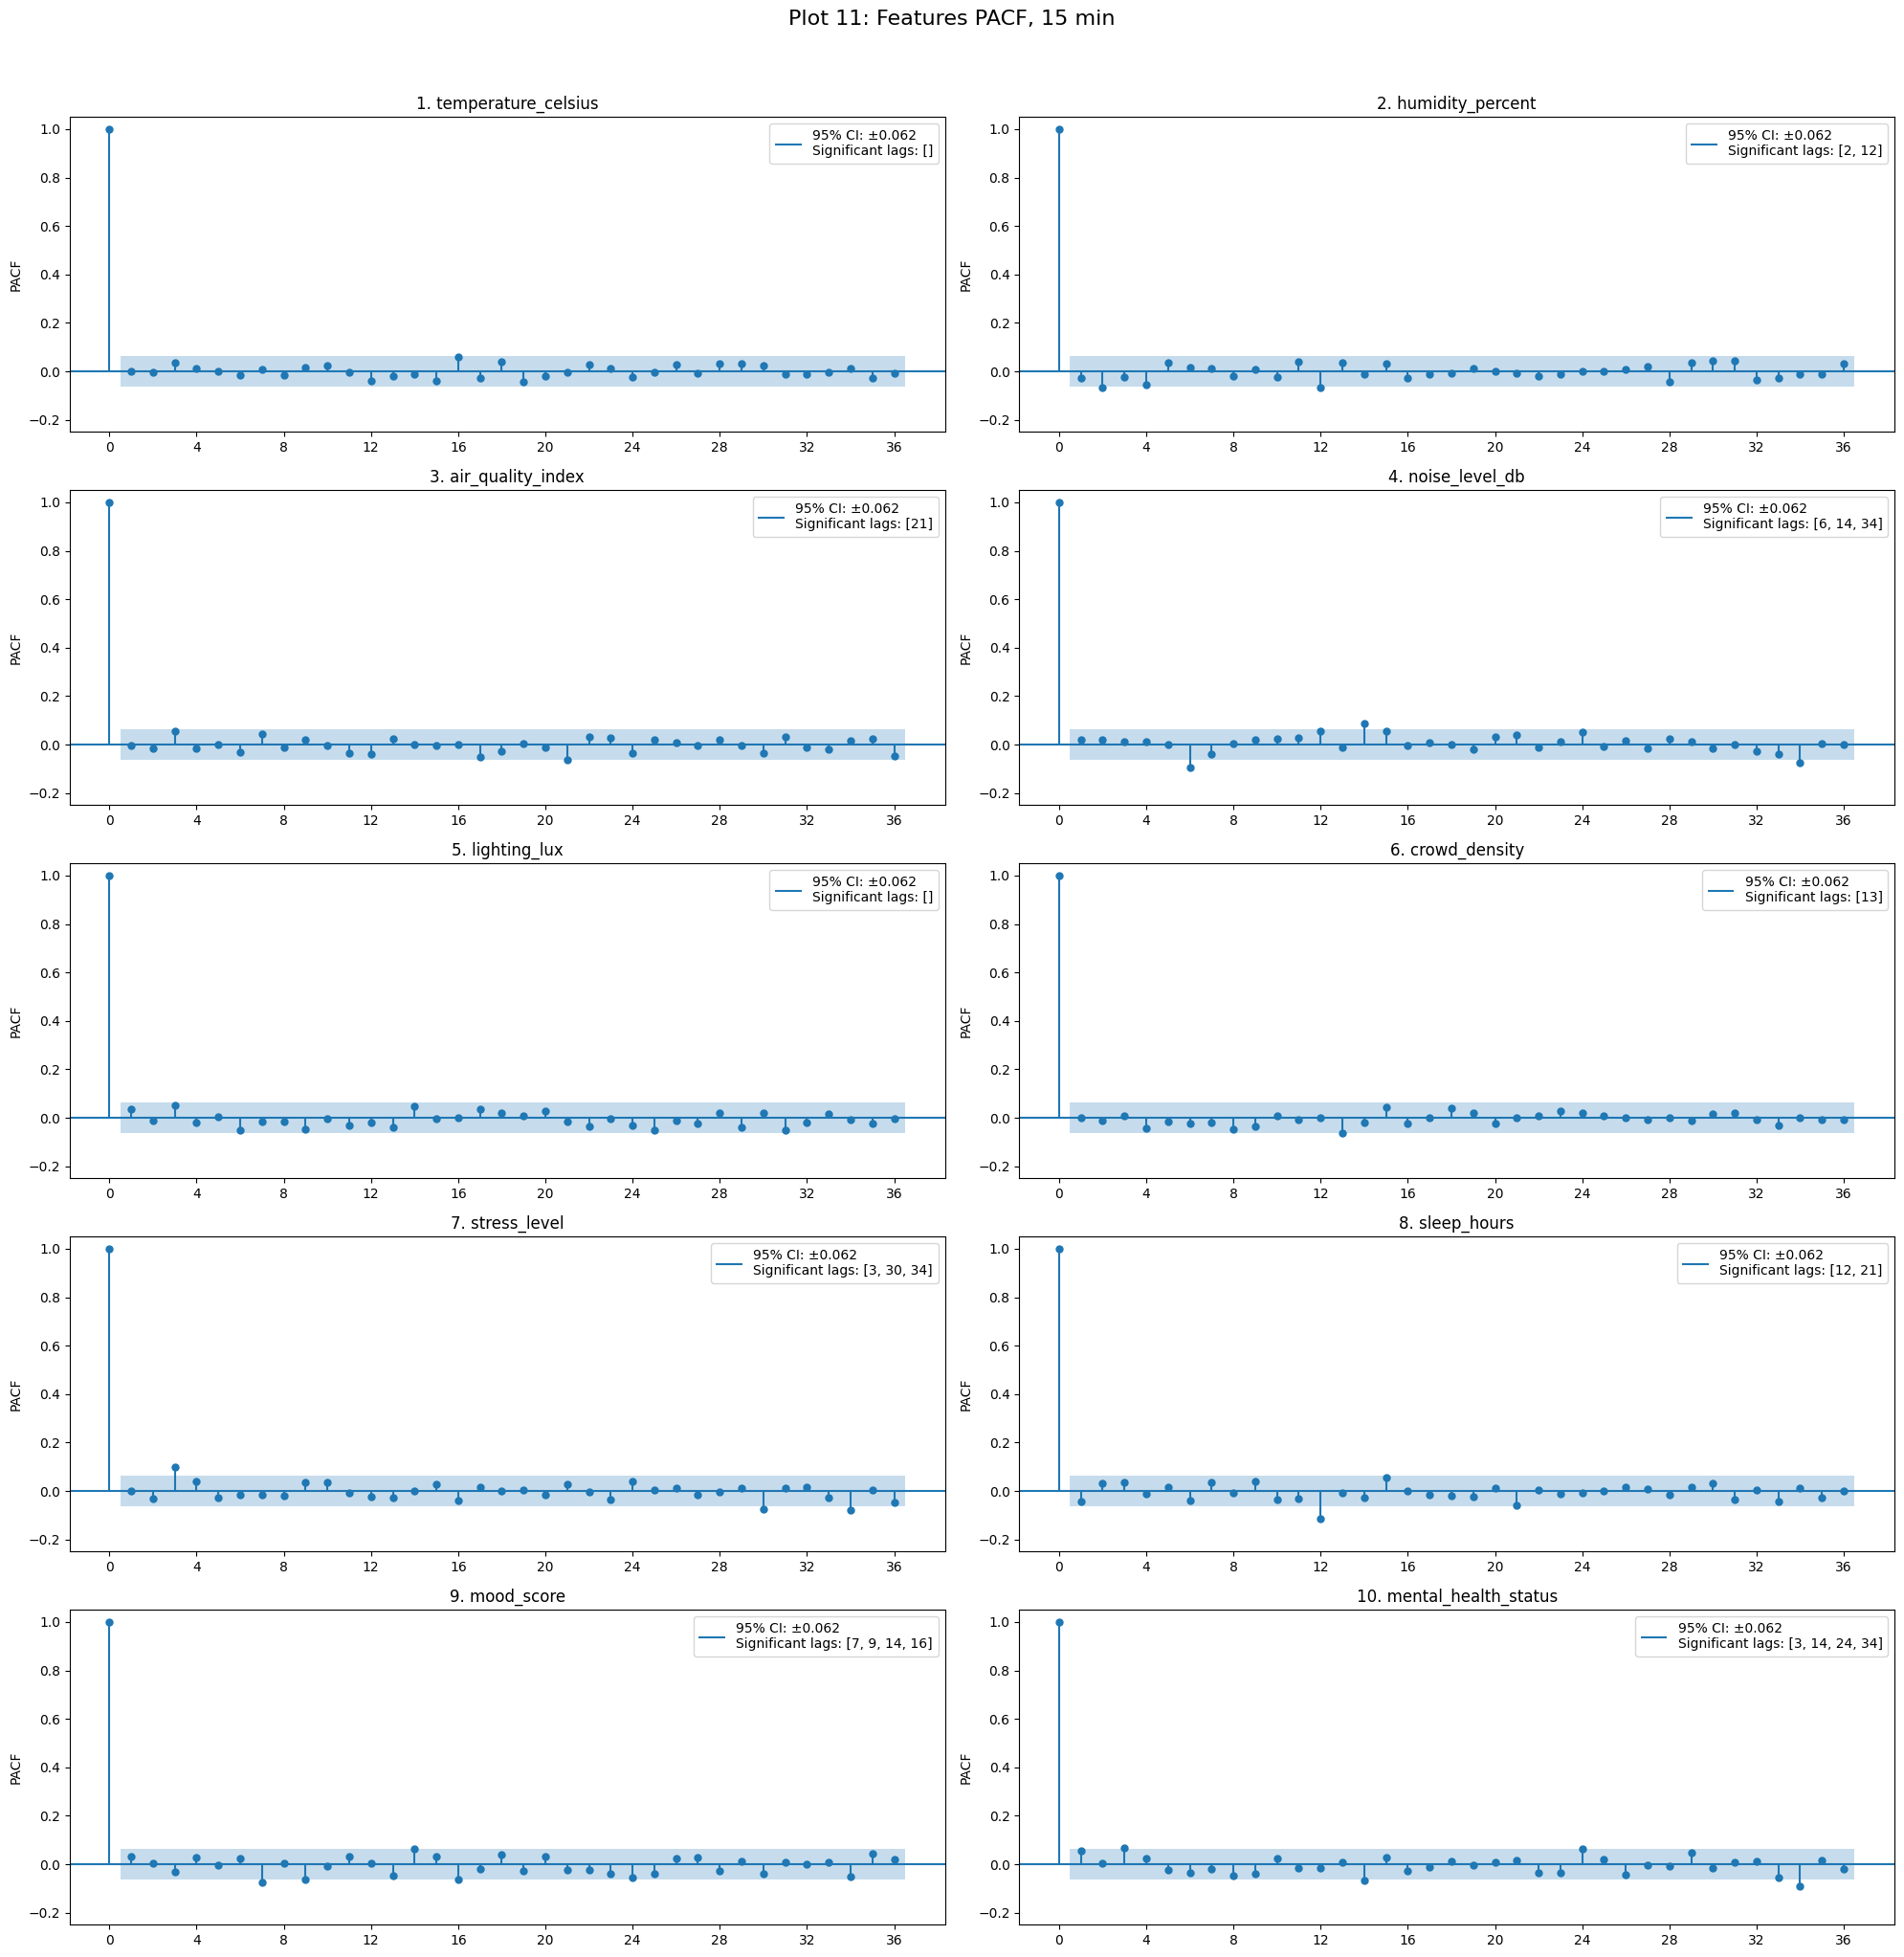

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 4), sharex=False)
pacf_15m = {}
axes = axes.flatten()
for i, col in enumerate(columns_to_plot):

    ax = axes[i]
    pacf_vals = pacf(plot_df[col].dropna(), nlags=36)
    threshold = 1.96 / (np.sqrt(len(plot_df[col].dropna()))) # == 95% CI
    pacf_15m[col] = [
        i for i, v in enumerate(pacf_vals[1:37], start=1)
        if abs(v) > threshold
    ]
    plot_pacf(plot_df[col], ax=ax, alpha = 0.05, lags=36)
    ax.set_title(f"{i+1}. {col}")
    ax.set_ylabel("PACF")
    legend_text = f"95% CI: ±{threshold:.3f}\nSignificant lags: {pacf_15m[col]}"
    ax.legend([legend_text], loc="upper right")
    ax.set_ylim(-0.25, 1.05)
    ax.set_xticks(list(range(0, 37, 4)))
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Plot 11: Features PACF, 15 min', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The plots above will serve as a reference for crafting lagged temporal features. These dependencies may not be immediate or sequential but could instead reflect delayed effects.

For example, consider the mood_score, which shows significant PACF lags at 7, 9, 14, and 16, corresponding to delays of approximately 1h45m, 2h15m, 3h30m, and 4h, respectively. This suggests that changes in mood may not impact the target variable immediately, but rather with some delay.

When engineering new features, I may include not only the current mood_score, but also its lagged values at steps 7 and 9, as these may hold predictive value for the outcome.

Let’s now try plotting the same analysis using data grouped by 1-hour intervals to explore whether these delayed effects become more pronounced at a coarser temporal resolution.

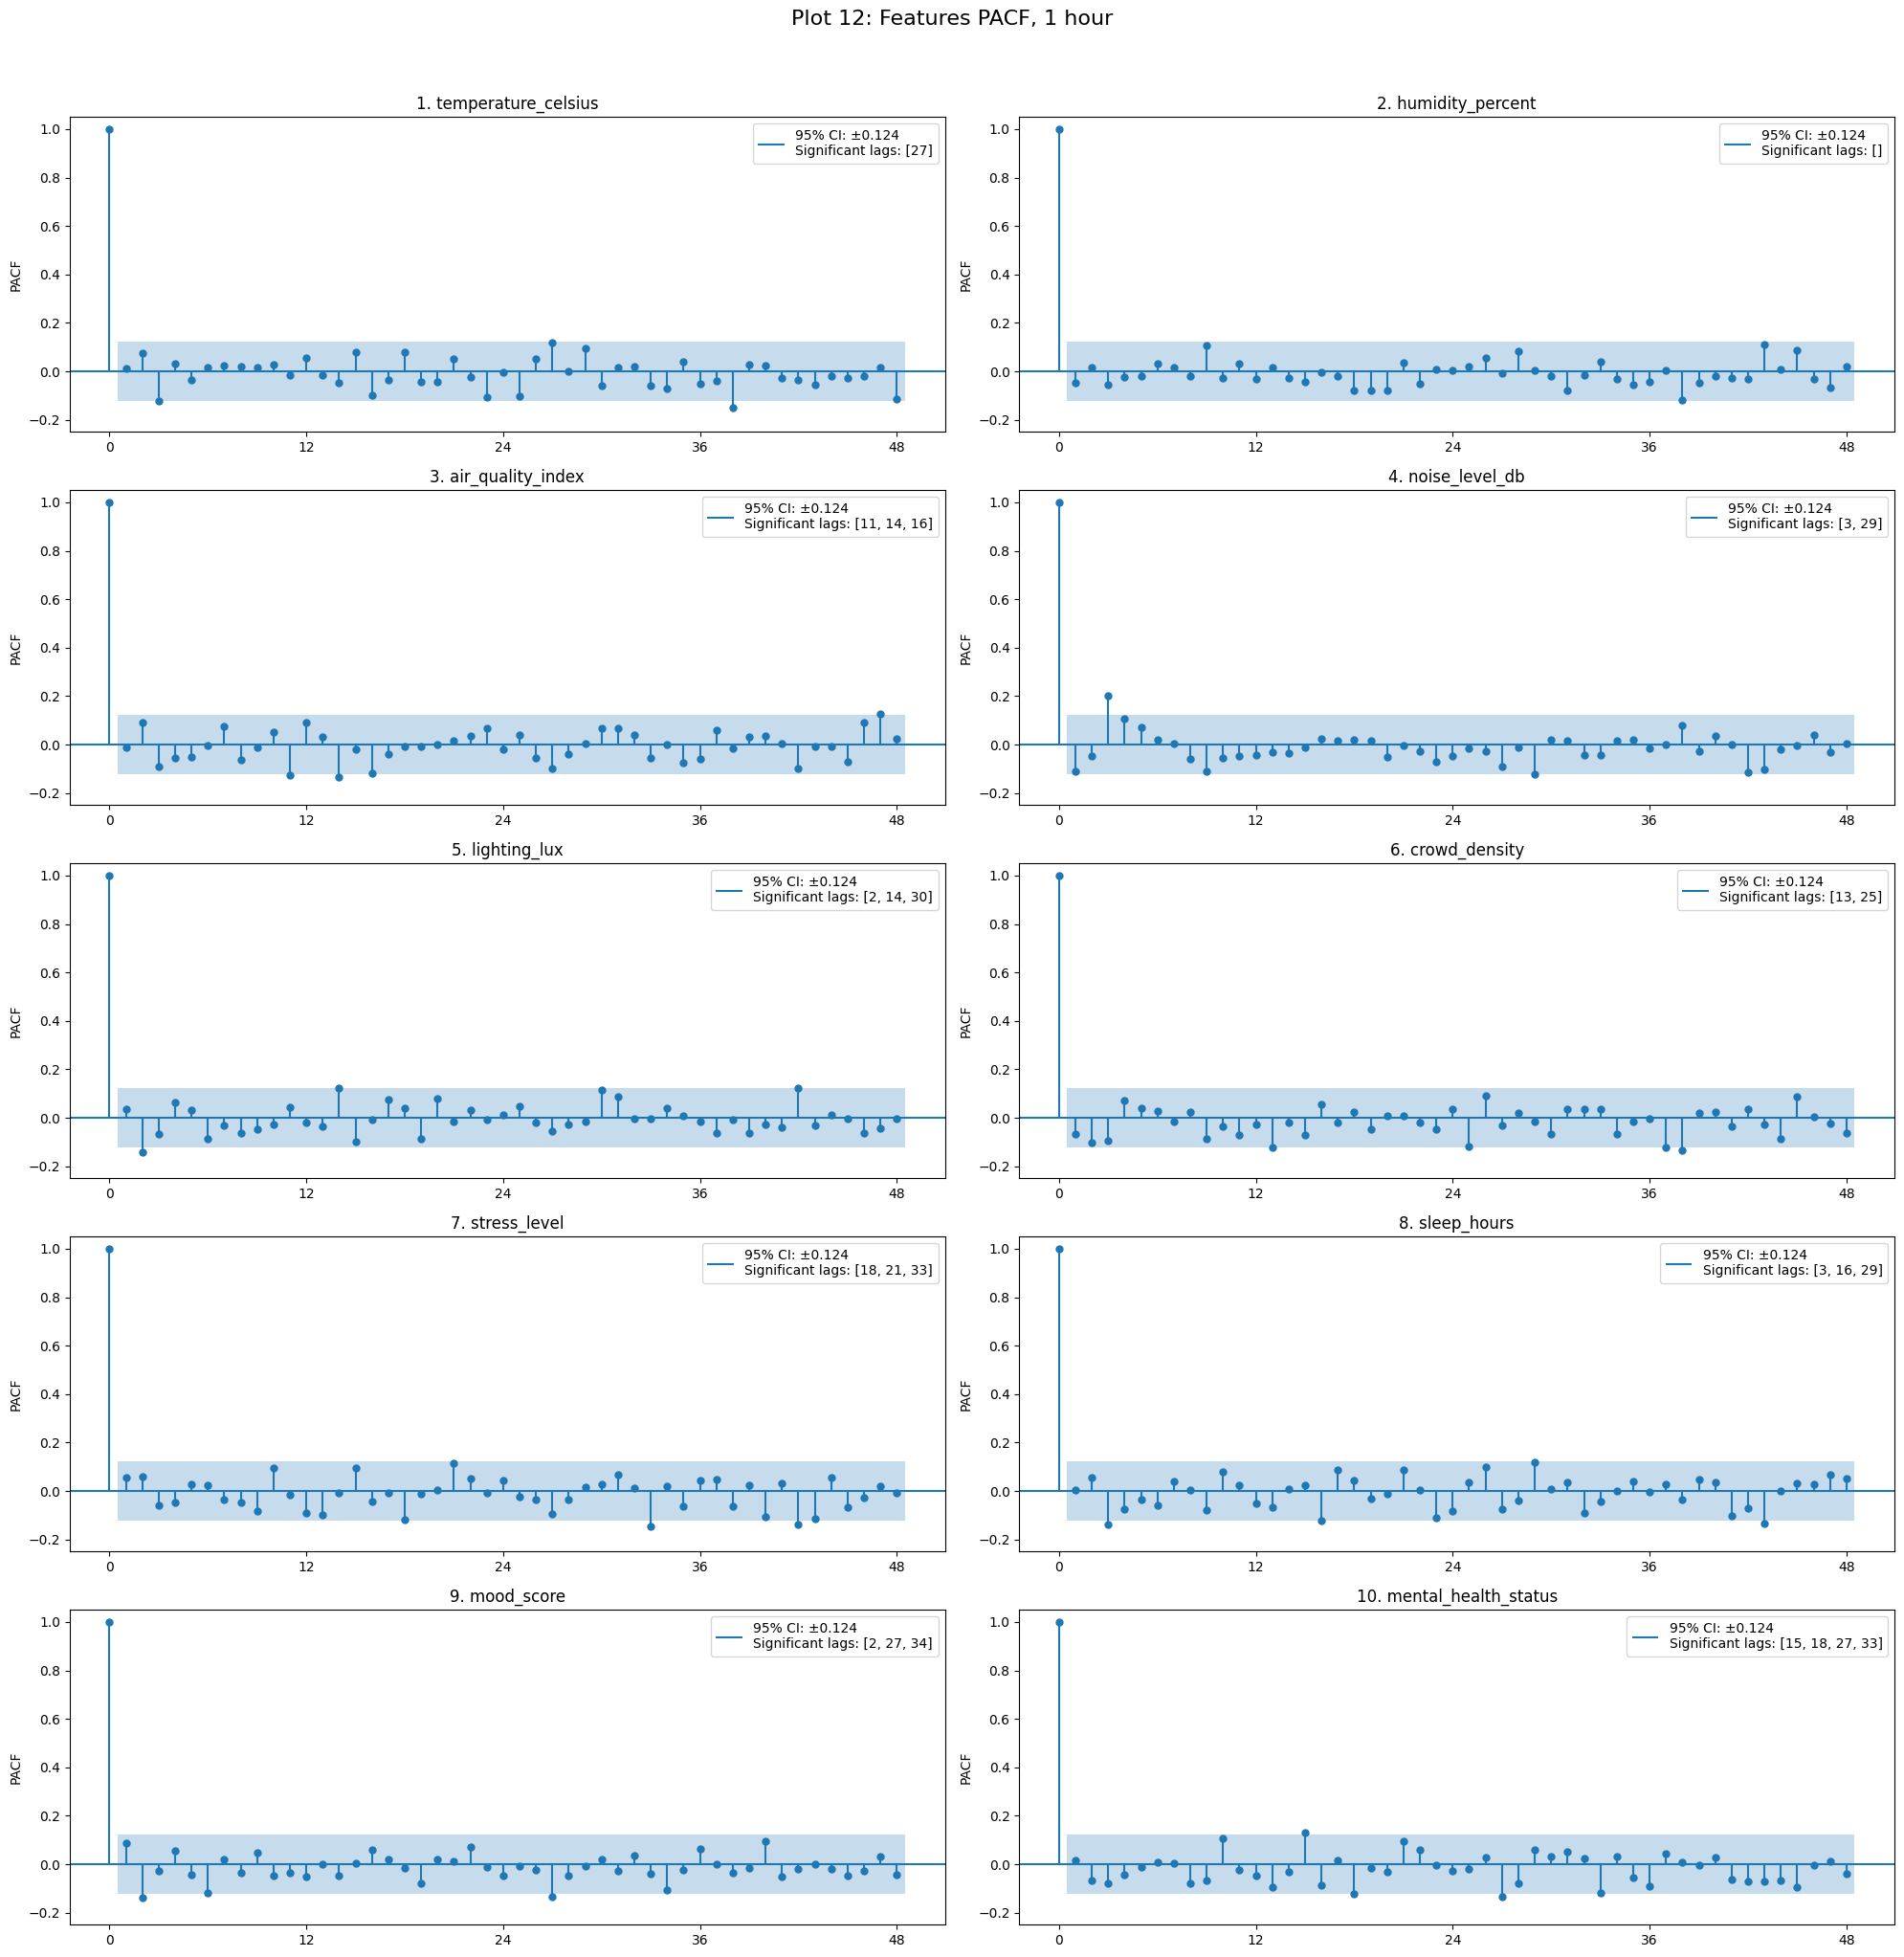

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 4), sharex=False)
pacf_1h = {}
axes = axes.flatten()
for i, col in enumerate(columns_to_plot):

    ax = axes[i]
    pacf_vals = pacf(hourly_df[col].dropna(), nlags=36)
    threshold = 1.96 / (np.sqrt(len(hourly_df[col].dropna()))) # == 95% CI
    pacf_1h[col] = [
        i for i, v in enumerate(pacf_vals[1:48], start=1) 
        if abs(v) > threshold
    ]
    plot_pacf(hourly_df[col], ax=ax, alpha = 0.05, lags=48)
    ax.set_title(f"{i+1}. {col}")
    ax.set_ylabel("PACF")
    legend_text = f"95% CI: ±{threshold:.3f}\nSignificant lags: {pacf_1h[col]}"
    ax.legend([legend_text], loc="upper right")
    ax.set_ylim(-0.25, 1.05)
    ax.set_xticks(list(range(0, 49, 12)))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.suptitle(f'Plot 12: Features PACF, 1 hour', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Grouping the data at 1-hour intervals helps reveal patterns on a broader, daily timescale. While we don’t observe strong short-term influences, certain specific hourly lags show direct partial correlations. This may hint at circadian effects or delayed behavioral and physiological responses.

For example, current stress levels may be influenced by stress experienced at the same time on the previous day: possibly due to a consistent schedule, such as work-related routines.

However, the absence of consistent spikes at regular intervals suggests that any cyclic behavior is either weak or irregular. This indicates the presence of delayed effects rather than clear, structured seasonality.

### 2.2.3 Seasonality Plots
While ACF and PACF plots are effective for capturing linear autocorrelations, they may not reveal strong spikes when the data is particularly nonlinear, irregular, or noisy, which is often the case with sensor-based data. To better capture potential cyclical patterns, we will explore the seasonal component of a time series decomposition.

For this demonstration, we scale the data to 2-hour intervals, an empirically chosen timeframe that allows us to highlight possible patterns. It's worth noting that the plots tend to exhibit signs of seasonality across various time intervals, not just at this specific resolution.

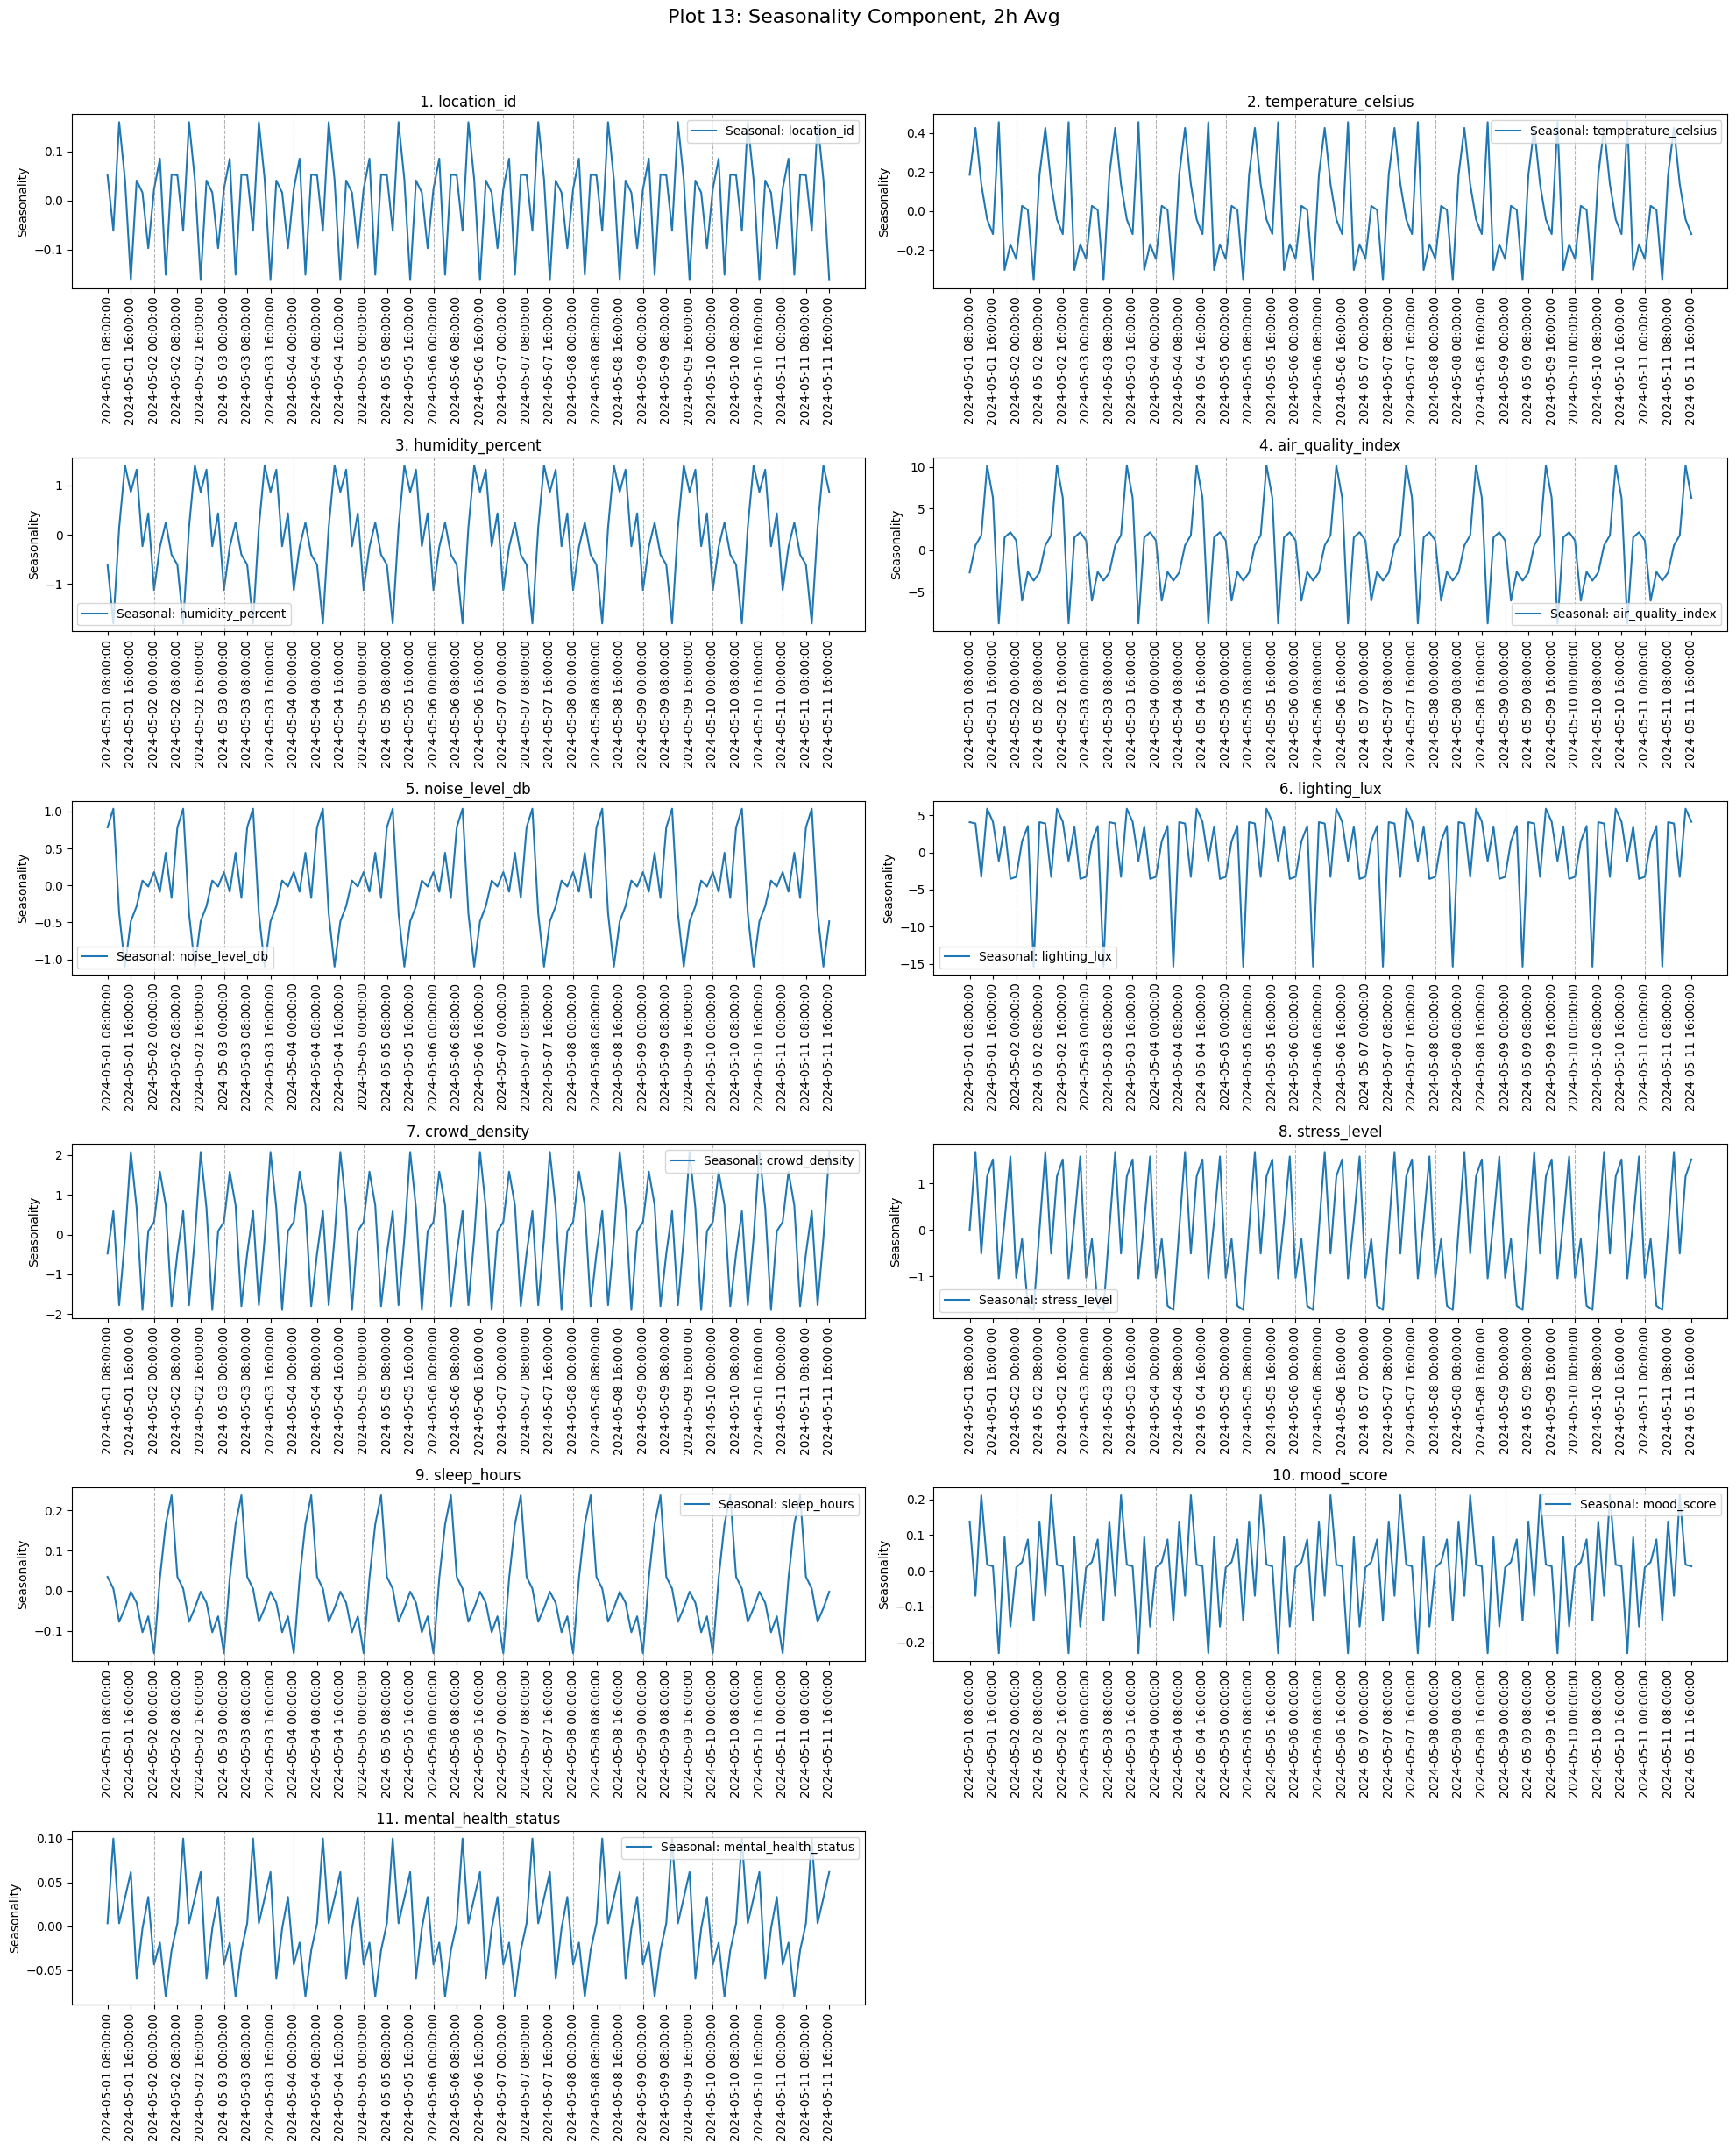

In [262]:
columns_to_plot = plot_df.columns.drop(['time_of_day'])

n_cols = 2
n_rows = math.ceil(len(columns_to_plot) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 4), sharex=False)
axes = axes.flatten()

resample_freq = '2h'
p = int(24*60/15/4/2)  # 2-hour seasonality period (from 15-min base)

midnights = plot_df.index[plot_df.index.time == pd.to_datetime("00:00:00").time()]
tick_locs = plot_df.index[::32]
tick_labels = plot_df.index[::32]

for i, (col, ax) in enumerate(zip(columns_to_plot, axes)):
    try:
        series = plot_df[col].resample(resample_freq).mean()
        result = seasonal_decompose(series, model='additive', period=p)
        ax.plot(result.seasonal, label=f'Seasonal: {col}')
        ax.set_title(f'{i+1}. {col}')
        ax.set_ylabel("Seasonality")
        for ts in midnights:
            ax.axvline(x=ts, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels, rotation=90)
        ax.legend()

    except ValueError as e:
        ax.set_visible(False)
        print(f"Skipping {col}: {e}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Plot 13: Seasonality Component, {resample_freq} Avg', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

Even location_id exhibits a seasonal pattern, suggesting that the individual may follow a routine involving daily travel or location changes.

Our analysis reveals that nearly every feature displays a clear seasonal component, indicating that many variables vary in a predictable manner over the course of the day or week. This has important implications:
- Some features may directly influence mental_health_status due to behavioral or physiological rhythms.
- Others may act as confounding variables, introducing time-based patterns that could mislead the model if not properly accounted for.

In [263]:
strengths = {}
for col in columns_to_plot:
    series = plot_df[col].dropna()
    result = seasonal_decompose(series, model='additive', period=96)  # 96 = 15m × 96 = 1 day
    var_resid = np.var(result.resid.dropna())
    var_seasonal = np.var(result.seasonal.dropna())

    strengths[col] = var_seasonal / (var_seasonal + var_resid)

print("=== Seasonality strength per feature:")
for k, v in sorted(strengths.items(), key=lambda item: item[1], reverse = True):
    print(k, v)

=== Seasonality strength per feature:
crowd_density 0.1327876607926907
air_quality_index 0.13100501863656533
noise_level_db 0.12365960700792918
stress_level 0.1198598257798879
sleep_hours 0.1179055612511699
mental_health_status 0.1109882309762372
humidity_percent 0.10758343887210832
lighting_lux 0.10353466999098625
location_id 0.09764322821456466
temperature_celsius 0.09269599874178076
mood_score 0.09258502446373945


## 3 Feature crafting
### 3.1 Temporal Dependencies

Based on the observed seasonality, we will now add lagged features to capture the delayed effects of predictors on the target variable. For example, the PACF plot suggests that a low mood_score may result in increased mental stress approximately two hours later. To account for such delayed relationships, we will include lagged versions of relevant features.

Notably, we will also include lagged values of the target variable itself as predictors. Given the seasonal and temporal dependencies observed, past values of mental_health_status could provide useful signals for future predictions.

In addition to lag-based features, we will also incorporate time-based features, such as indicators for weekends and the day of the week, as these may correlate with behavioral patterns and mental state.

#### On Lag Limits and Data Size
After several iterations, we chose to limit the number of lags to 50 (equivalent to 12.5 hours) due to practical considerations in time series modeling. As the lag window increases, so does the number of rows containing NaN values , introduced due to the shift operations required to create lagged features. These rows must be dropped before training, which can significantly reduce the size of the dataset.

For instance, using a lag of 200 (25 hours) resulted in the loss of approximately 200 rows | or about 20% of the dataset (assuming ~1,000 total rows). This reduction negatively impacted training and generalization performance. Therefore, to explore longer lags (e.g., 24–48 hours), we would need a substantially larger dataset to maintain sufficient training samples after lagging.

In [265]:
model_df = plot_df.copy()
model_df['hour'] = model_df.index.hour
model_df['weekday'] = model_df.index.weekday
model_df['is_weekend'] = model_df['weekday'].isin([5, 6]).astype(int)

# !cyclic encoding for smooth transitions (better for trees or deep learning)
model_df['hour_sin'] = np.sin(2 * np.pi * model_df['hour'] / 24)
model_df['hour_cos'] = np.cos(2 * np.pi * model_df['hour'] / 24)

#lagged features
def add_lag_features(df, columns, lags, max_lags=50):
    for col in columns:
        for lag in lags:
            if lag < max_lags:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

for col in pacf_15m:
    if pacf_15m[col]:
        model_df = add_lag_features(model_df, [col], lags=pacf_15m[col])

for col in pacf_1h:
    if pacf_1h[col]:
        lag_list_15min = [lag * 4 for lag in pacf_1h[col]]
        model_df = add_lag_features(model_df, [col], lags=lag_list_15min)
model_df.dropna(inplace=True)
#model_df.bfill(inplace=True)
print('Crafted dataset size:', model_df.shape)


Crafted dataset size: (956, 41)


# 4 Model
## 4.1. Model Selection
### 4.1.2 Random Forest

After experimenting with various hyperparameter combinations, I finalized a Random Forest model using a tuned set of parameters (params1), which had been precomputed and saved during earlier iterations.

In [266]:
params1 = {
 'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

target = 'mental_health_status'
feature_cols = model_df.columns.drop('mental_health_status').drop('time_of_day')

X = model_df[feature_cols]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(**params1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[97  0]
 [ 0 95]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        95

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



The model performed very well, with only a single instance where mental_health_status was '0' being misclassified as '1'. This indicates strong overall predictive performance.

Next, let’s examine the list of features ranked in descending order of importance:

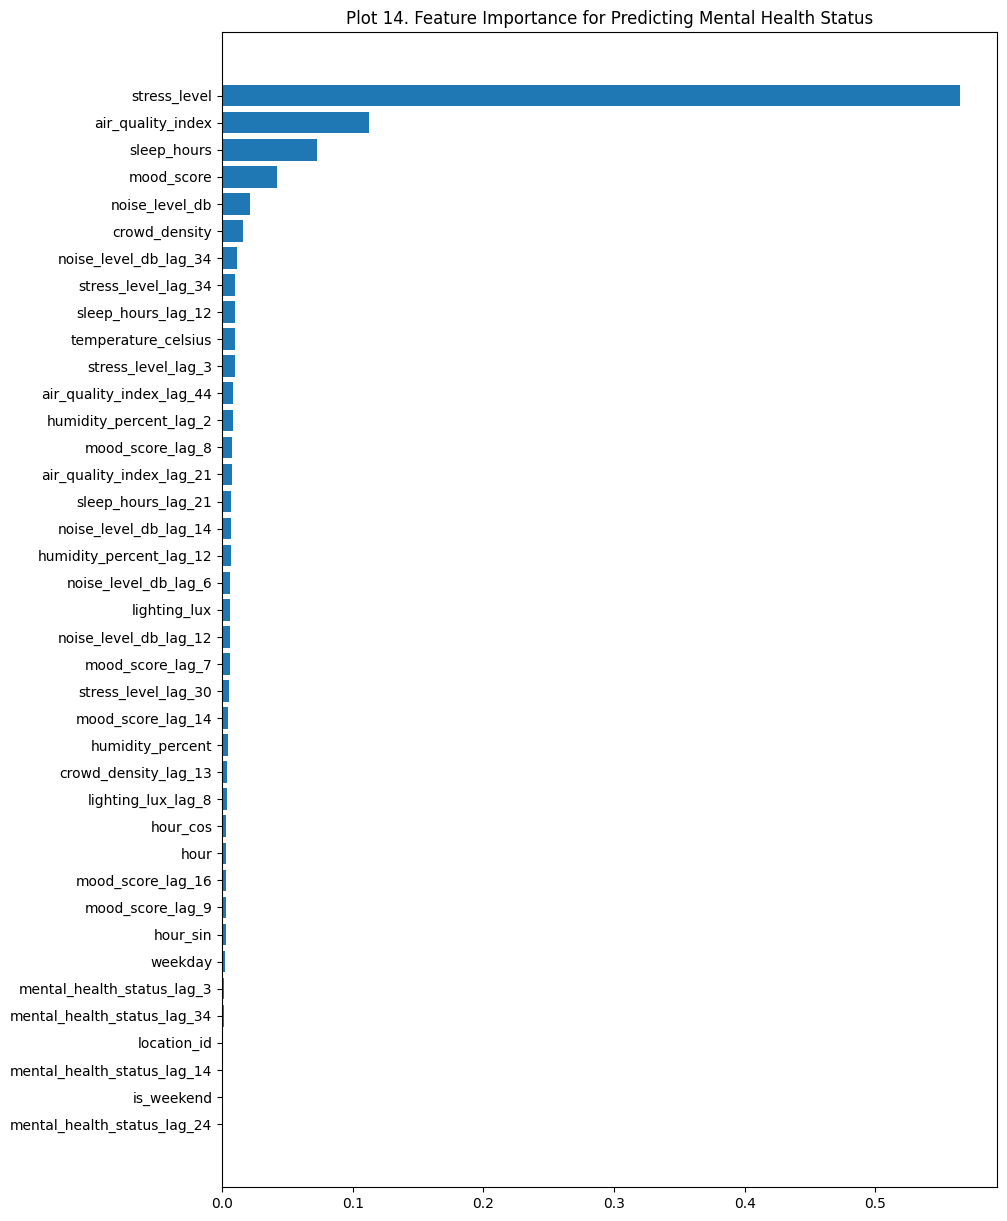

In [267]:
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 15))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.title('Plot 14. Feature Importance for Predicting Mental Health Status')
plt.show()

It appears that the number of engineered features — particularly lagged features — may have been excessive for this model. In hindsight, the model might have performed similarly well even without them. While some lagged features did appear among the top 10 most important variables, their practical interpretability is questionable.

For instance, temperature_celsius_108 corresponds to a lag of 108 steps, or approximately 27 hours (108 * 15 min / 60 min= 1,620/60). Is it realistic to assume that temperature nearly a day and a half ago has a direct impact on current mental health status? Possibly, but such a hypothesis would require additional domain knowledge or empirical validation in a production setting.

Now, let’s take a look at the SHAP values for the top 45 features:

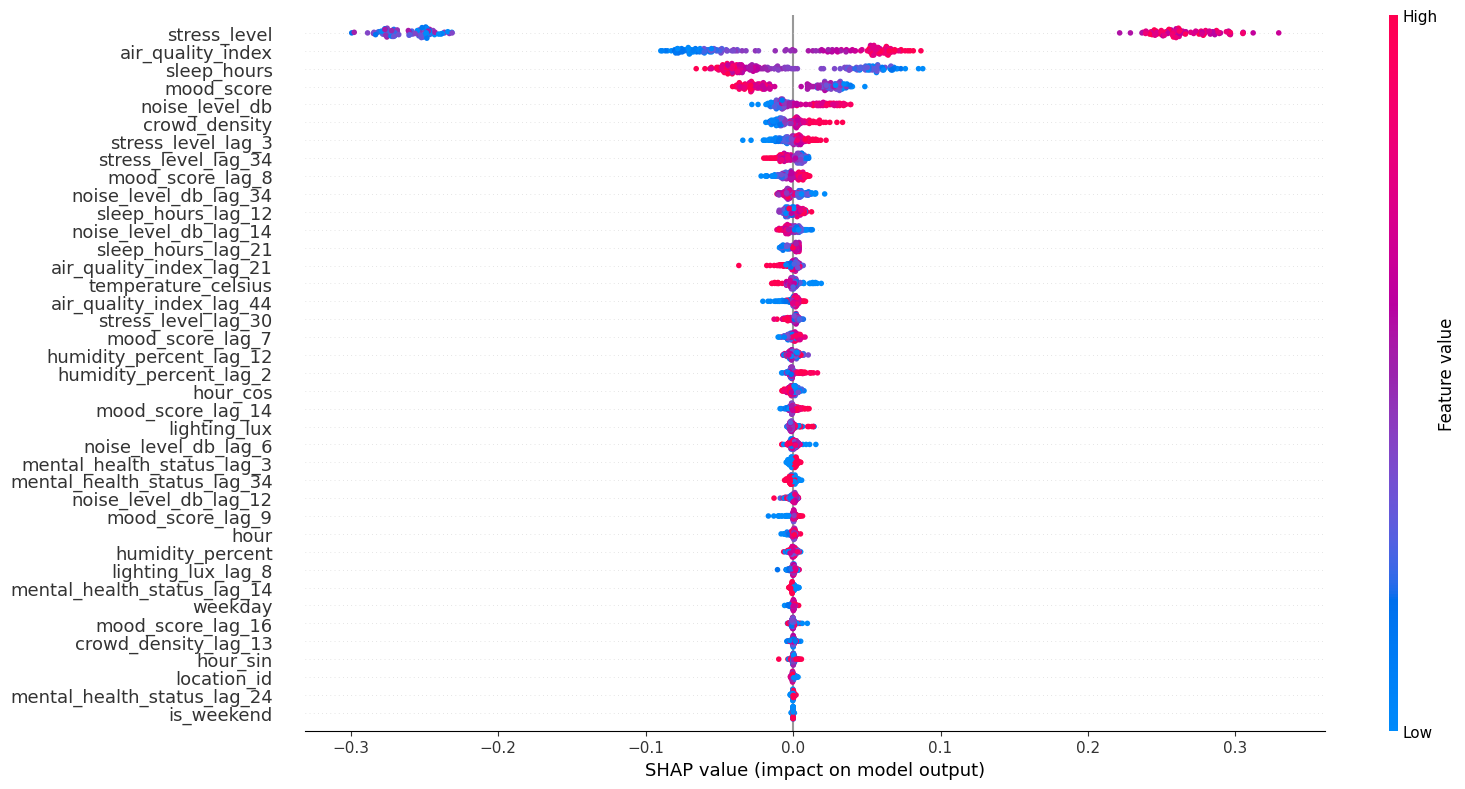

In [52]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:,:,1], X_test, max_display=45, plot_size=(16, 8))

Interestingly, the SHAP values provide more practical interpretability for the lagged features that appeared in the top 10. For example:

- stress_level_lag_3 corresponds to a 45-minute delay,
- stress_level_lag_34 represents approximately 8.5 hours (a longer lag, but still plausible as a delayed effect),
- mood_score_lag_8 reflects a 2-hour delay.

These features suggest that certain physiological or emotional states may influence mental_health_status after a time lag, aligning with the idea that some effects take time to manifest.

In [53]:
mean_abs_shap = np.abs(shap_values[:,:,1]).mean(axis=0)
shap_feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)
top15_features = shap_feature_importance.head(15)['feature'].tolist()
print("Top 15 SHAP features:")
print(shap_feature_importance.head(15).to_string(index=False))

Top 15 SHAP features:
                 feature  mean_abs_shap
            stress_level       0.263673
       air_quality_index       0.055450
             sleep_hours       0.039574
              mood_score       0.026281
          noise_level_db       0.013153
           crowd_density       0.007906
      stress_level_lag_3       0.006429
     stress_level_lag_34       0.005660
        mood_score_lag_8       0.005372
   noise_level_db_lag_34       0.005137
      sleep_hours_lag_12       0.003910
   noise_level_db_lag_14       0.003571
      sleep_hours_lag_21       0.003128
air_quality_index_lag_21       0.002986
     temperature_celsius       0.002924


The Random Forest model performed exceptionally well, achieving 100% accuracy on the current dataset. Given this performance, there may be little need for further tuning at this stage. However, based on my experience, an alternative model such as XGBoost could also be a strong candidate — especially given its ability to better capture interactions among temporal features and produce more refined feature importance rankings.

While XGBoost is generally slower to train compared to Random Forest, the difference is negligible on a dataset of this size (~1,000 rows). That said, looking ahead, it's important to plan for scalability. As the dataset grows, XGBoost will become increasingly computationally expensive to re-train and re-tune over time. Conversely, while Random Forest trains faster, its accuracy may degrade with more complex or larger datasets, making it less competitive compared to XGBoost in the long run.

It's also worth emphasizing that the primary goal of this assignment is not necessarily to build a production-ready predictive model for mental_health_status, but rather to extract meaningful insights from the data. Therefore, my focus is more on interpreting and comparing feature importance across models than on maximizing predictive accuracy.

### 4.1.3 XGBoost

These parameters were optimized based on earlier experimentation to balance accuracy, generalization, and computational efficiency.

In [ ]:
params = {
 'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


In [ ]:
X = model_df[feature_cols]#top15_features]
y = model_df['mental_health_status']

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_2 = XGBClassifier(
**params
)

model_2.fit(X_train2, y_train2)
#model_2.save_model("assets/xgb_model.json")
y_pred2 = model_2.predict(X_test2)

print(confusion_matrix(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2))

[[97  0]
 [ 0 95]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        95

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



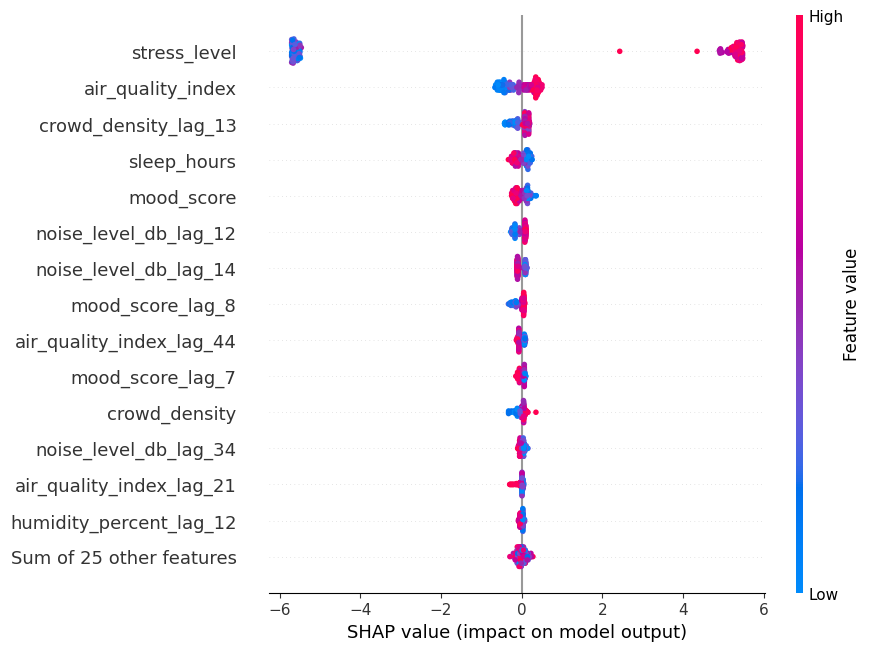

In [86]:
explainer_2 = shap.Explainer(model_2, X_train2)
shap_values_2 = explainer_2(X_test2)

shap.plots.beeswarm(shap_values_2, max_display=15)

In [87]:
mean_abs_shap_2 = np.abs(shap_values_2.values).mean(axis=0)

shap_feature_importance_2 = pd.DataFrame({
    'feature': X_test2.columns,
    'mean_abs_shap': mean_abs_shap_2
}).sort_values(by='mean_abs_shap', ascending=False)
top15_features = shap_feature_importance_2.head(15)['feature'].tolist()

print("Top 15 SHAP features:")
print(shap_feature_importance_2.head(15).to_string(index=False))


Top 15 SHAP features:
                 feature  mean_abs_shap
            stress_level       5.446338
       air_quality_index       0.353921
    crowd_density_lag_13       0.160939
             sleep_hours       0.141358
              mood_score       0.131459
   noise_level_db_lag_12       0.109244
   noise_level_db_lag_14       0.096501
        mood_score_lag_8       0.090351
air_quality_index_lag_44       0.072364
        mood_score_lag_7       0.065798
           crowd_density       0.065243
   noise_level_db_lag_34       0.041786
air_quality_index_lag_21       0.040564
 humidity_percent_lag_12       0.037496
     stress_level_lag_30       0.033971


XGBoost performed as good, however it picked different features as important. Let's overview both models:

Comparison of 15 top shap values across the models:
| **Random Forest**              | **mean_abs_shap** | **XGBoost**                   | **mean_abs_shap** |
|--------------------------------|-------------------|-------------------------------|-------------------|
| stress_level                   | 0.263673          | stress_level                  | 5.446338          |
| air_quality_index              | 0.055450          | air_quality_index             | 0.353921          |
| sleep_hours                    | 0.039574          | crowd_density_lag_13          | 0.160939          |
| mood_score                     | 0.026281          | sleep_hours                   | 0.141358          |
| noise_level_db                 | 0.013153          | mood_score                    | 0.131459          |
| crowd_density                  | 0.007906          | noise_level_db_lag_12         | 0.109244          |
| stress_level_lag_3            | 0.006429          | noise_level_db_lag_14         | 0.096501          |
| stress_level_lag_34           | 0.005660          | mood_score_lag_8              | 0.090351          |
| mood_score_lag_8              | 0.005372          | air_quality_index_lag_44      | 0.072364          |
| noise_level_db_lag_34         | 0.005137          | mood_score_lag_7              | 0.065798          |
| sleep_hours_lag_12            | 0.003910          | crowd_density                 | 0.065243          |
| noise_level_db_lag_14         | 0.003571          | noise_level_db_lag_34         | 0.041786          |
| sleep_hours_lag_21            | 0.003128          | air_quality_index_lag_21      | 0.040564          |
| air_quality_index_lag_21      | 0.002986          | humidity_percent_lag_12       | 0.037496          |
| temperature_celsius           | 0.002924          | stress_level_lag_30           | 0.033971          |


Let’s now compare the above SHAP-based feature importance with the correlation matrix (Plot 8), which offers additional insight into the linear relationships between the features and the target variable, mental_health_status.

Notably, stress_level exhibits a strong positive correlation with the target (r = 0.80), reinforcing its dominant position in the SHAP rankings for both Random Forest and XGBoost. In contrast, features such as sleep_hours and mood_score show moderate to strong negative correlations (r = -0.40 and r = -0.19, respectively), suggesting that improvements in sleep or mood are associated with a lower likelihood of mental health concerns.

Interestingly, while features like air_quality_index and crowd_density display only moderate linear correlations with the target (r = 0.55 and r = 0.19), they still ranked highly in SHAP importance. This discrepancy suggests that non-linear relationships or lagged effects may play a significant role in predicting mental health status — patterns that tree-based models such as XGBoost are particularly well-suited to capture.

Furthermore, the generally weak correlations among most input features indicate low multicollinearity, which is favorable for both model robustness and interpretability. It ensures that the model can assign importance more cleanly without confounding effects between highly correlated predictors.

# 5. Conclusion

We conducted a focused analysis of the IoT sensory dataset, including outlier detection and handling, exploration of linear correlations, timestamp decomposition, and the engineering of lag-based and seasonal features to account for delayed and periodic effects. Notably, all features demonstrated some degree of non-linear seasonality, which informed our feature crafting strategy.

Let’s now review the key findings from comparing SHAP values produced by the two models: Random Forest (RF) and XGBoost (XGB):
- stress_level emerged as the most important feature in both models by a wide margin. In XGBoost, its SHAP value is an order of magnitude higher than the next most important feature.
- air_quality_index consistently appeared in the top 2–3 features for both models.
- noise_level_db and its lagged variants were also ranked highly in both models.
- humidity_percent_lag_12 was identified as important by XGBoost but not by Random Forest.
- XGBoost tends to rank lagged features higher than RF, likely due to its ability to better capture temporal interactions.
- Random Forest includes some lagged features, but their SHAP values are typically lower, indicating less influence.
- XGBoost identifies more subtle lagged effects, such as: humidity_percent_lag_12, stress_level_lag_30, air_quality_index_lag_21
- Random Forest relies more heavily on main-effect features, such as sleep_hours and mood_score.
- Several core features: stress_level, air_quality_index, sleep_hours, and mood_score — appear in the top 10 for both models, reinforcing their relevance.

Note: To interpret lagged features in terms of time, divide the lag index by 4 (or multiply by 15/60) to convert from 15-minute intervals to hours.
For example, crowd_density_lag_13 corresponds to a delay of 13 / 4 = 3.25 hours (i.e., 3 hours and 15 minutes).